# Bands clustering

In this notebook, we cluster bands by genre, theme, and date/location to find connections between bands.

Bands are sorted by their founding date, so it would be easier to find the origins of certain genres or themes.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

bands = pd.read_csv('data/ma_bands_data.csv', index_col=0).sort_values('date').reset_index(drop=True)

In [2]:
bands['theme'] = bands['theme'].fillna('')

In [3]:
bands

name                                                url  \
0               Olympic  https://www.metal-archives.com/bands/Olympic/3...   
1                Orient  https://www.metal-archives.com/bands/Orient/51156   
2             Scorpions  https://www.metal-archives.com/bands/Scorpions...   
3       Faithful Breath  https://www.metal-archives.com/bands/Faithful_...   
4             Limelight  https://www.metal-archives.com/bands/Limelight...   
...                 ...                                                ...   
129466          כף הקלע  https://www.metal-archives.com/bands/%D7%9B%D7...   
129467     ᛋᚢᚱᛏᚱ ᚹᛟᚢᚾᛞᛋ  https://www.metal-archives.com/bands/%E1%9B%8B...   
129468          こくまろみるく  https://www.metal-archives.com/bands/%E3%81%93...   
129469          ノストラダムス  https://www.metal-archives.com/bands/%E3%83%8E...   
129470               鐵男  https://www.metal-archives.com/bands/%E9%90%B5...   

                                                    genre  \
0                   Pop Rock; Heavy Metal/Hard Rock (mid)   
1                  Hard Rock (early); Heavy Metal (later)   
2                                   Heavy Metal/Hard Rock   
3       Progressive Rock (early); Heavy Metal/Hard Roc...   
4                            NWOBHM/Heavy Metal/Hard Rock   
...                                                   ...   
129466                       Black/Death Metal/Crust Punk   
129467                      Raw Black Metal, Dark Ambient   
129468                           Experimental Power Metal   
129469                                  Progressive Metal   
129470                       Sludge Metal/Grindcore/Noise   

                                                    theme  \
0                                                           
1                                        ['Sex', ' Evil']   
2       ['Life', ' Society', ' Love', ' Sex', ' Inner ...   
3                     ['Adventure', ' Fantasy', ' Women']   
4             ['Life', ' Feelings', ' Love', ' Thoughts']   
...                                                   ...   
129466                                                      
129467                                                      
129468                        ['The bizarre', ' Macabre']   
129469                                                      
129470                                                      

                       label         country  \
0                        NaN         Czechia   
1       Unsigned/independent         Czechia   
2                        NaN         Germany   
3                        NaN         Germany   
4                        NaN  United Kingdom   
...                      ...             ...   
129466  Unsigned/independent          Israel   
129467                   NaN  United Kingdom   
129468  Unsigned/independent           Japan   
129469                   NaN           Japan   
129470                   NaN           Japan   

                                   location        status    date  \
0                                    Prague        Active  1962.0   
1                                    Prague        Active  1964.0   
2                    Hannover, Lower Saxony        Active  1964.0   
3            Witten, North Rhine-Westphalia  Changed name  1967.0   
4       Mansfield, Nottinghamshire, England      Split-up  1967.0   
...                                     ...           ...     ...   
129466                         Haifa, Haifa        Active     NaN   
129467                                  NaN        Active     NaN   
129468                                  NaN        Active     NaN   
129469                                  NaN      Split-up     NaN   
129470                                  NaN      Split-up     NaN   

                                          years  
0                                  1962-present  
1                        1964-1990,1998-present  
2                                  1964-present  
3       19

# Vectorization

First of all, I need to vectorize the genres that each band belongs to, with 0 or 1 denoting whether a band belongs to a specific genre.

A band that belongs to both black metal and death metal would often be labelled as "Black/Death Metal", so I decided to drop the words "Metal" and "Rock", and "/" would be considered a separator. Since there are also metal genres fused together like "Industrial Black Metal", I consider such bands belonging to both "Industrial" and "Black" genres as they exhibit traits from both. Some bands changed genres as they developed, and I consider them to belong in all the genres they have ever been in. Labels like "(early)", "(mid)", or "(later)" would be dropped. Bands labelled as "with X influences" would be simply considered as belonging in "X" genre.

There have been some very specific labelled that occurred very few times, which I consider as errors. I dropped words that occurred less than 10 times. Since identifying bands belonging in niche genres is something that interests us, the threshold is kept small.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True, token_pattern="middle eastern|[0-9a-z'\-]+", min_df=10,
                             stop_words=['metal', 'rock', "'n'", 'roll', 'early', 'mid', 'later',
                                         'and', 'elements', 'influences', 'various', 'with'])
genre_mat = vectorizer.fit_transform(bands['genre'])
genre_names = vectorizer.get_feature_names_out()
print(genre_names)

['acoustic' 'alternative' 'ambient' 'aor' 'atmospheric' 'avant-garde'
 'black' 'blackened' 'blues' 'brutal' 'celtic' 'classical' 'crossover'
 'crust' 'crustcore' 'cybergrind' 'd-beat' 'dark' 'darkwave' 'death'
 'deathcore' 'depressive' 'djent' 'doom' 'drone' 'dungeon' 'electronic'
 'electronica' 'epic' 'experimental' 'extreme' 'folk' 'funeral' 'funk'
 'fusion' 'glam' 'goregrind' 'gothic' 'grind' 'grindcore' 'groove'
 'grunge' 'hard' 'hardcore' 'heavy' 'industrial' 'jazz' 'mathcore'
 'medieval' 'melodic' 'metalcore' 'middle eastern' 'neoclassical'
 'neofolk' 'noise' 'noisecore' 'noisegrind' 'nu-metal' 'nwobhm' 'oi'
 'operatic' 'pagan' 'pop' 'post-black' 'post-hardcore' 'post-metal'
 'post-punk' 'post-rock' 'power' 'powerviolence' 'progressive'
 'psychedelic' 'punk' 'rac' 'raw' 'shoegaze' 'shred' 'slam' 'sludge'
 'southern' 'speed' 'stoner' 'symphonic' 'synth' 'technical' 'thrash'
 'viking']


A special case would be bands belonging in "Middle Eastern Folk" genres, as "Middle Eastern" is two words, which could lead to confusion between "Middle Eastern" and "Eastern". So I treated it differently in the regex.

In [5]:
bands[bands['genre'].str.lower().str.contains('eastern')].head()

name                                                url  \
5825       Pentagram  https://www.metal-archives.com/bands/Pentagram...   
13991  Orphaned Land  https://www.metal-archives.com/bands/Orphaned_...   
16744      Melechesh  https://www.metal-archives.com/bands/Melechesh...   
21990       Blaakyum  https://www.metal-archives.com/bands/Blaakyum/...   
24727      Distorted  https://www.metal-archives.com/bands/Distorted...   

                                                   genre  \
5825   Thrash Metal (early); Heavy/Middle Eastern Fol...   
13991  Doom/Death/Middle Eastern Folk Metal (early); ...   
16744              Black/Death/Middle Eastern Folk Metal   
21990             Thrash/Heavy/Middle Eastern Folk Metal   
24727  Gothic/Melodic Death Metal with Middle Eastern...   

                                                   theme  \
5825   ['Metal', ' War', ' Misery (early); Suicide', ...   
13991        ['Abrahamic religions', ' Unity', ' Peace']   
16744                         ['Mesopotamian mythology']   
21990  ['Conceptual (thematic)', ' Symbolic', ' Socia...   
24727           ['Depression', ' Romance', ' Hypocrisy']   

                      label        country  \
5825                    NaN        Türkiye   
13991                   NaN         Israel   
16744                   NaN  International   
21990  Unsigned/independent        Lebanon   
24727                   NaN         Israel   

                                                location  status    date  \
5825                                            Istanbul  Active  1987.0   
13991           Bat Yam, Tel Aviv / Petah Tikva, Central  Active  1992.0   
16744  Jerusalem/Bethlehem (early); Netherlands/Franc...  Active  1993.0   
21990                            Beirut / Antelias, Matn  Active  1995.0   
24727                                  Bat Yam, Tel Aviv  Active  1996.0   

                                       years  
5825          1987-present,2001-present (as)  
13991  1991-1992 (as),1992-1997,2001-present  
16744                           1993-present  
21990                 1995-2001,2007-present  
24727                 1996-2010,2022-present

The vectorization of themes are different in a way that each quoted or parenthesized is treated as a token. Though labels like "(early)", "(mid)", or "(later)" would be dropped.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True, token_pattern="[0-9a-z][0-9a-z'\-/\s]*[0-9a-z]", min_df=10,
                             stop_words=['early', 'mid', 'later'])
theme_mat = vectorizer.fit_transform(bands['theme'])
theme_names = vectorizer.get_feature_names_out()
print(theme_names)

['abandonment' 'aberrations' 'abortion' ... 'youth' 'zombie' 'zombies']


In [7]:
bands[bands['theme'].str.lower().str.contains('early').fillna(False)].head()

name                                                url  \
9    Sir Lord Baltimore  https://www.metal-archives.com/bands/Sir_Lord_...   
72              Rainbow   https://www.metal-archives.com/bands/Rainbow/108   
122        Diamond Head  https://www.metal-archives.com/bands/Diamond_H...   
387                  V8       https://www.metal-archives.com/bands/V8/3236   
404           Nightmare  https://www.metal-archives.com/bands/Nightmare...   

                             genre  \
9            Heavy Metal/Hard Rock   
72           Hard Rock/Heavy Metal   
122  NWOBHM, Heavy Metal/Hard Rock   
387                    Heavy Metal   
404              Heavy/Power Metal   

                                                 theme                 label  \
9    ['Love', ' Women', ' Life (early); Christianit...  Unsigned/independent   
72   ['Fantasy', ' Rock (early); Relationships', ' ...                   NaN   
122  ['Fantasy', ' Fiction', ' Love (early); Societ...                   NaN   
387  ['Violence', ' Rebellion', ' Religion', ' Soci...                   NaN   
404  ['Life', ' Rock (early); Fantasy', ' Armageddo...                   NaN   

            country                                          location  \
9     United States                                New York, New York   
72    United States  Los Angeles, California / Connecticut / New York   
122  United Kingdom               Stourbridge, West Midlands, England   
387       Argentina                                      Buenos Aires   
404          France                    Grenoble, Auvergne-Rhône-Alpes   

       status    date                                       years  
9    Split-up  1968.0                    1968-1972,1977,2005-2006  
72     Active  1975.0  1975 (as),1976-1984,1994-1997,2015-present  
122    Active  1976.0            1976-1985,1991-1994,2000-present  
387  Split-up  1979.0                              1979-1987,1996  
404    Active  1979.0                      1979-1988,1999-present

As the size of data is quite large, K-means clustering is used. We use silhouette coefficient to benchmark the performance of clustering at different number of clusters.

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def kmeans_benchmark(data, x):
    y = list()
    
    for n in x:
        kmeans = KMeans(n_clusters=n, random_state=0)
        kmeans.fit(data)
        #print('fit', n, end='\r')
        y.append(silhouette_score(data, kmeans.labels_, sample_size=1000, random_state=0))
        #print('score', n, end='\r')

    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette coefficient')
    plt.plot(x, y);

The following is to discover whether each cluster has a tendency towards certain genres or themes. This is done by a matrix multiplication, which averages the genre or theme vectors of the bands belonging to each cluster.

In [9]:
from scipy.sparse import csr_matrix

def vec_avg(n_tot, index, labels, n_clusters, mat):
    selector = csr_matrix((np.ones(index.shape[0]), (labels, index)),
                          (n_clusters, n_tot))
    return selector / selector.sum(axis=1) * mat

# 1. By Genre

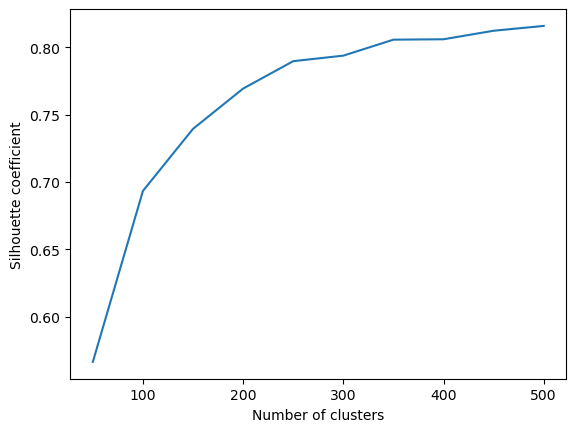

In [10]:
kmeans_benchmark(genre_mat, range(50, 550, 50))

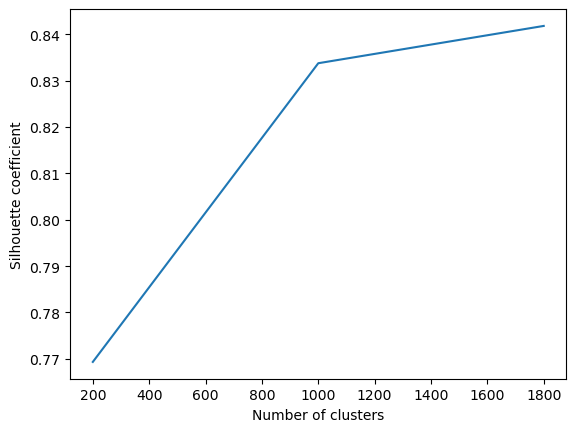

In [14]:
kmeans_benchmark(genre_mat, range(200, 2600, 800))

Although the theoretical optimal number of clusters would be the point that maximizes the silhouette coefficient, we decided to set the number of clusters to 300 for the sake of simplifying the analysis, as further increase in the number of clusters only result in relatively small improvements.

You might be asking that, aren't metal bands already categorized, or clustered together in their respective genres? But as the vectorization part has shown, many metal bands cannot be fit into a single genre. There also exists many subgenres and intersections between genres. These all prove the necessity to cluster metal bands by their genres.

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=300, random_state=0)
kmeans.fit(genre_mat)
kmeans.labels_

array([ 5,  5,  5, ...,  6, 14, 29], dtype=int32)

In [16]:
groups = bands.groupby(kmeans.labels_)
groups.size()

0       1838
1       3690
2      10898
3        984
4      15623
       ...  
295       30
296       36
297       20
298       26
299       18
Length: 300, dtype: int64

These are the 5 earliest bands within each genre cluster.

In [17]:
groups['name'].apply(lambda x: x.iloc[: 5].reset_index(drop=True)).unstack()

0                    1                   2  \
0              Turbo         Witch Slayer  Wrathchild America   
1                Rax              Alucard     Benefits Forgot   
2          Graf Spee          Necrophagia           Imperator   
3          Nifleheim       Fiendish Nymph      Ancient Wisdom   
4         Skull Face       Veneno Maldito              Mayhem   
..               ...                  ...                 ...   
295    Black Messiah           Inchiuvatu    Nokturnal Mortum   
296  Infernal Poetry  Serenity in Silence               Spire   
297     Manilla Road              Полигон           Enchanter   
298           Aethra              Skylark      伝承歌劇団～エウロパの軌跡～   
299          Der Tod                Mytra              Transe   

                               3               4  
0                  Warlock Texas             Raw  
1                       Cenotaph       Hypocrite  
2                    Аясын Салхи          Belial  
3                           Bran  Thy Repentance  
4                   Sacred Hades          Fantom  
..                           ...             ...  
295                  Ashen Light       Munruthel  
296  Incoming Cerebral Overdrive           Abyss  
297               Ageless Wisdom        Marauder  
298                Eddy Antonini    Orion Riders  
299                     Qwestion      Metatronik  

[300 rows x 5 columns]

These are the most important genres sorted descending according to the average of the genre weights.

In [18]:
top_pos = np.argsort(kmeans.cluster_centers_)[:, -1 : -6 : -1]
genre_names[top_pos]

array([['heavy', 'thrash', 'melodic', 'black', 'crossover'],
       ['melodic', 'death', 'heavy', 'viking', 'epic'],
       ['death', 'heavy', 'avant-garde', 'power', 'stoner'],
       ...,
       ['heavy', 'power', 'epic', 'black', 'folk'],
       ['symphonic', 'melodic', 'power', 'hard', 'gothic'],
       ['industrial', 'progressive', 'electronic', 'psychedelic',
        'experimental']], dtype=object)

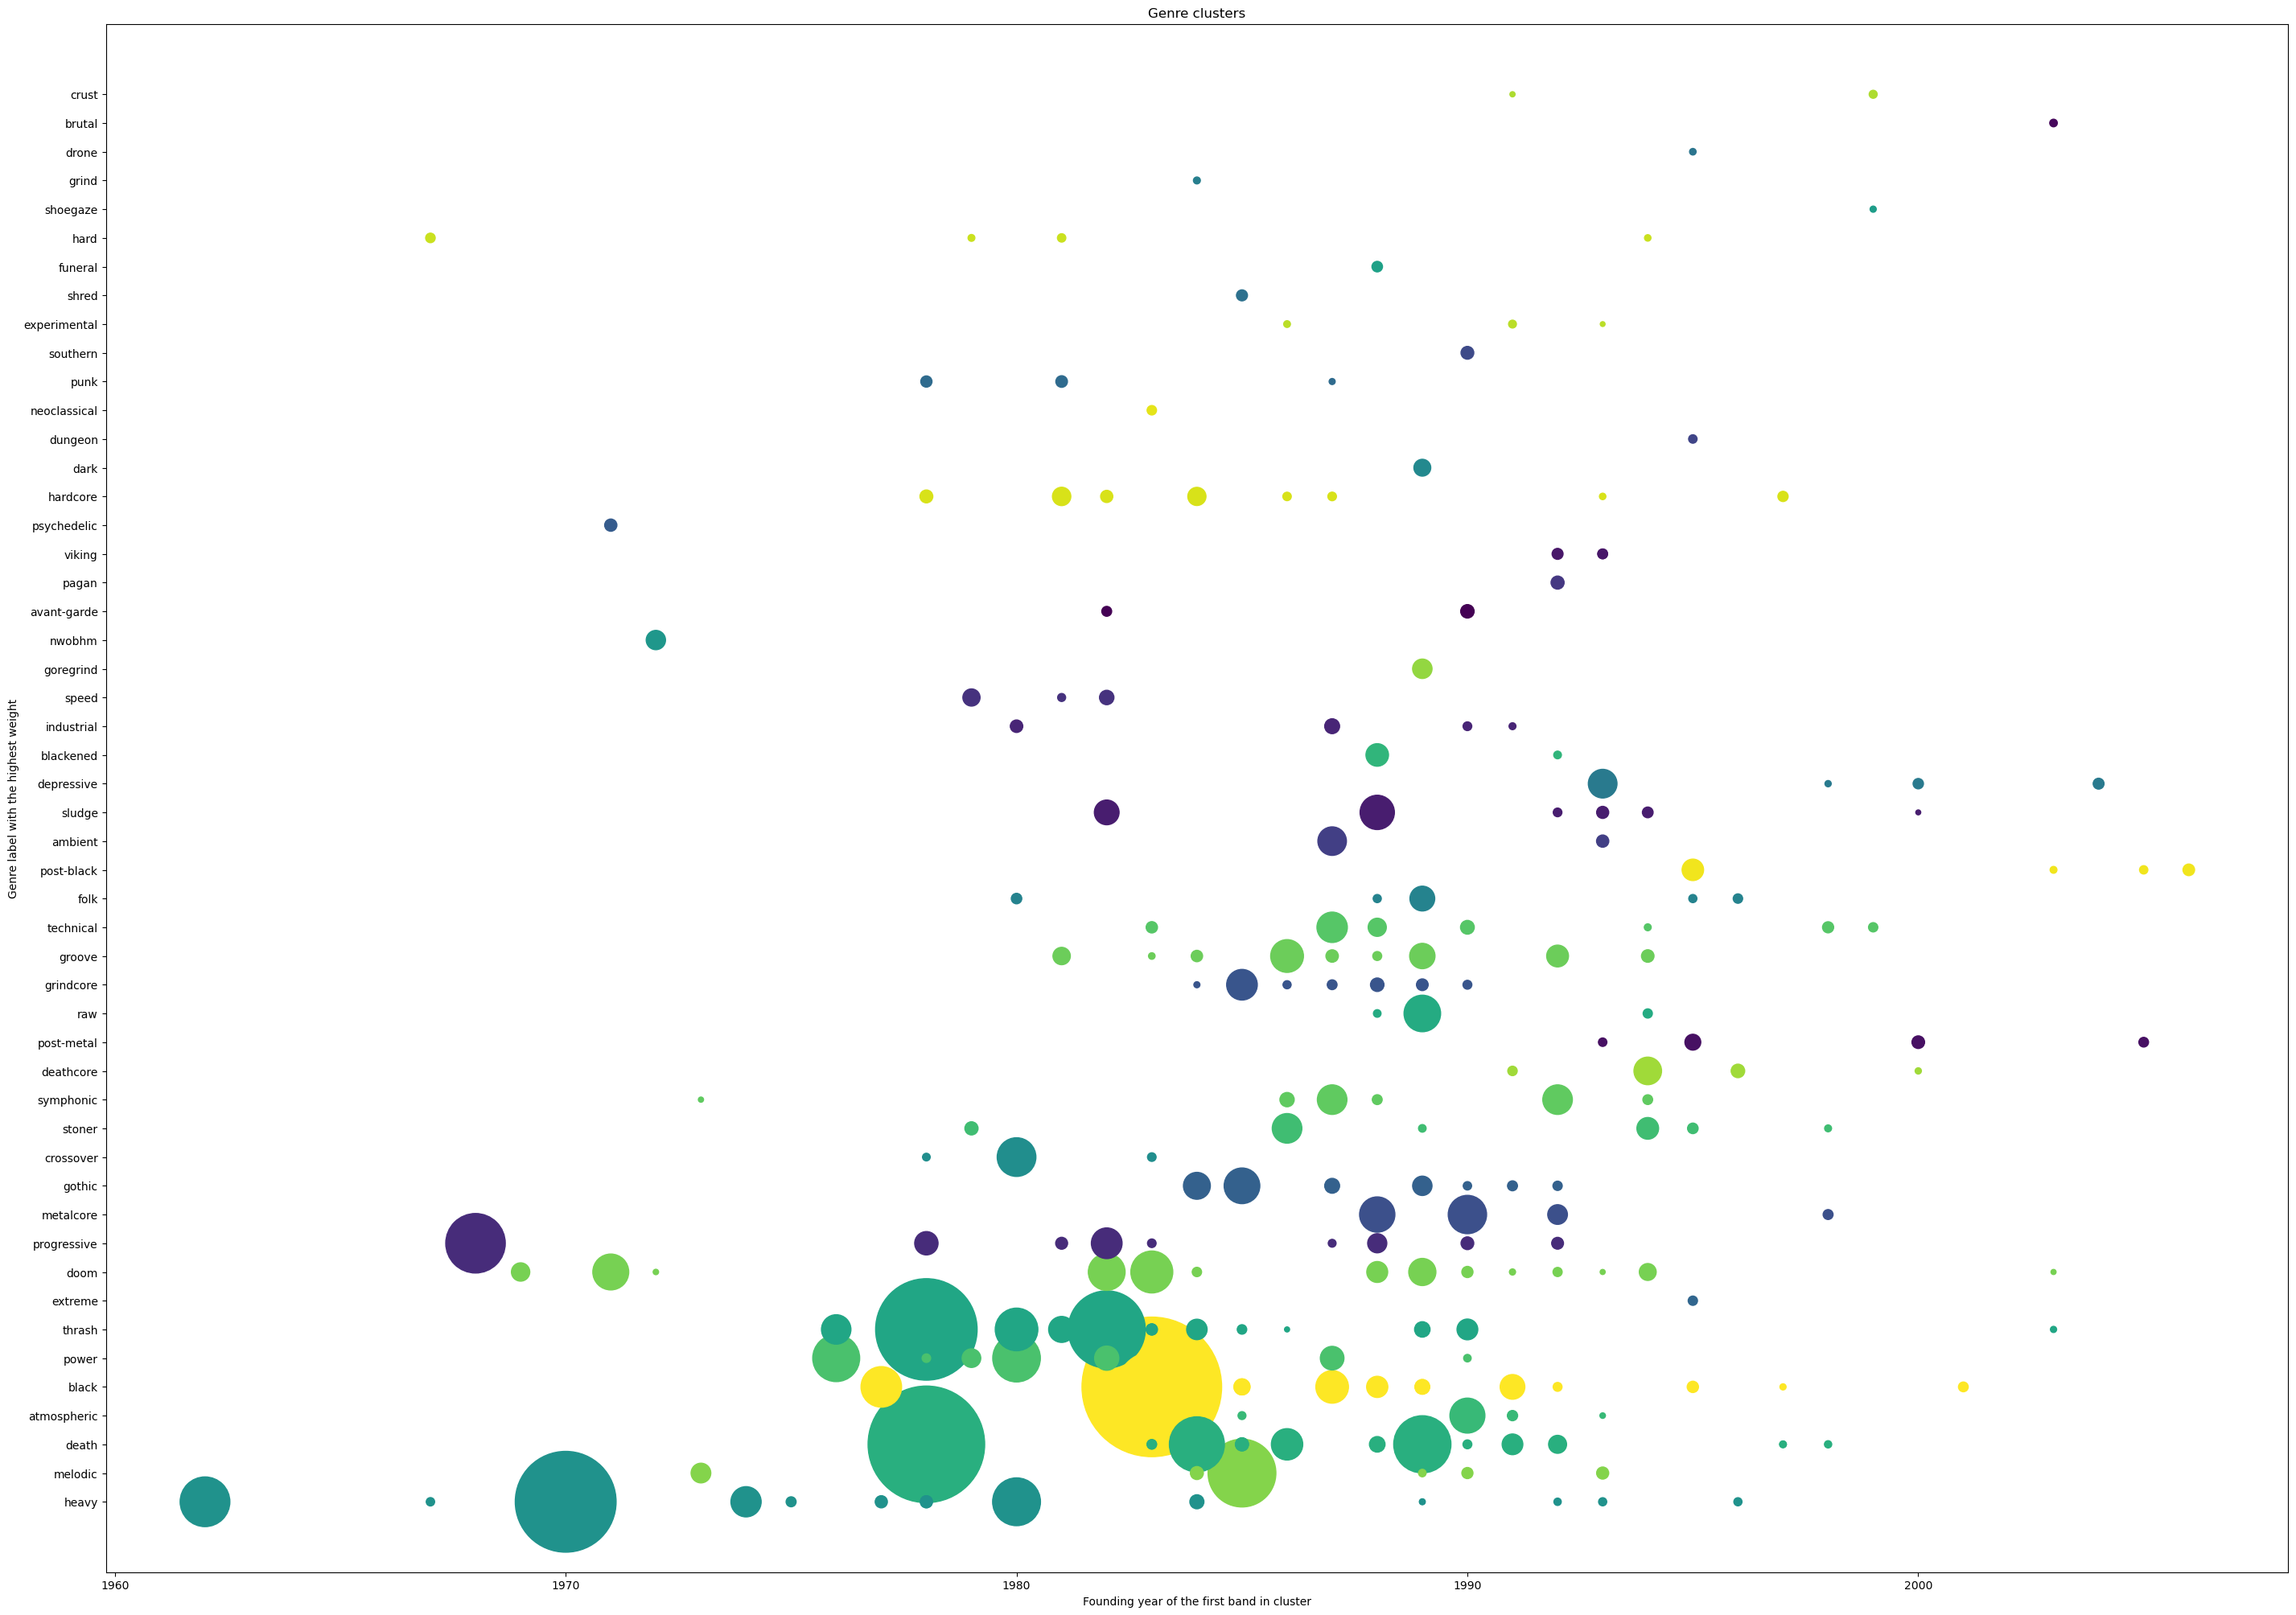

In [19]:
arr=genre_names[top_pos]

x=[]
c=[]
for i in range(len(arr)):
    x.append((arr[i][0]))
to_id = {v: i for i, v in enumerate(set(x))}
for i in range(len(arr)):
    c.append(to_id[(arr[i][0])])

weight=[]
for i in range(len(arr)):
    weight.append(groups.size()[i])
weight
w=np.array(weight)

plt.figure(figsize=(35,25))
plt.title('Genre clusters')
plt.xlabel('Founding year of the first band in cluster')
plt.ylabel('Genre label with the highest weight')
plt.scatter(groups['date'].first().astype(int),x,s=w,cmap='viridis', c=c);

These are the average weights of the most important genres.

In [20]:
top = np.sort(kmeans.cluster_centers_)[:, -1 : -6 : -1]
np.round(top, 2)

array([[1.  , 1.  , 0.02, 0.01, 0.01],
       [1.  , 1.  , 0.01, 0.01, 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       ...,
       [1.  , 1.  , 1.  , 0.1 , 0.05],
       [1.  , 1.  , 1.  , 0.04, 0.04],
       [1.  , 1.  , 0.11, 0.06, 0.06]])

The following is to discover whether each genre cluster has a tendency towards certain themes.

In [21]:
theme_by_genre = vec_avg(bands.shape[0], bands.index, kmeans.labels_, kmeans.cluster_centers_.shape[0], theme_mat)

These are the most important themes sorted descending according to the average of the theme weights.

In [22]:
top_pos = np.argsort(theme_by_genre)[:, -1 : -6 : -1]
theme_names[top_pos]

array([['war', 'death', 'society', 'life', 'politics'],
       ['death', 'war', 'life', 'society', 'darkness'],
       ['death', 'gore', 'war', 'violence', 'horror'],
       ...,
       ['fantasy', 'history', 'battles', 'metal', 'war'],
       ['fantasy', 'love', 'nature', 'dreams', 'wizards'],
       ['instrumental', 'science fiction', 'mythology', 'feelings',
        'romanticism']], dtype=object)

These are the average weights of the most important themes.

In [23]:
top = np.sort(theme_by_genre)[:, -1 : -6 : -1]
np.round(top, 2)

array([[0.05, 0.05, 0.04, 0.04, 0.03],
       [0.11, 0.04, 0.04, 0.03, 0.03],
       [0.25, 0.11, 0.06, 0.05, 0.04],
       ...,
       [0.45, 0.2 , 0.1 , 0.1 , 0.1 ],
       [0.31, 0.19, 0.08, 0.08, 0.04],
       [0.17, 0.11, 0.06, 0.06, 0.06]])

# 2. By Theme

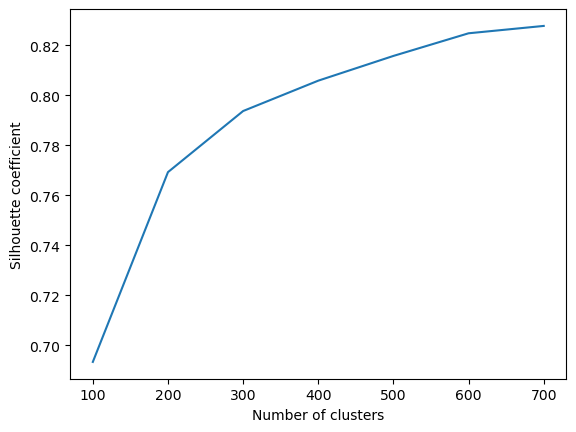

In [25]:
kmeans_benchmark(genre_mat, range(100, 800, 100))

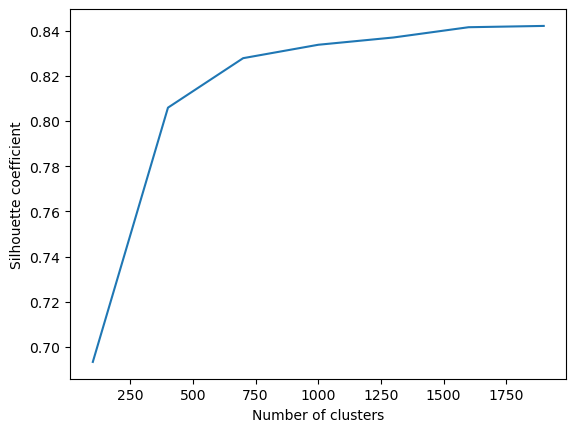

In [26]:
kmeans_benchmark(genre_mat, range(100, 2000, 300))

The number of clusters according to themes is set at 700, also for the ease of analysis. 

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=700, random_state=0)
kmeans.fit(theme_mat)
kmeans.labels_

array([  1, 234, 175, ...,   1,   1,   1], dtype=int32)

In [28]:
groups = bands.groupby(kmeans.labels_)
groups.size()

0         22
1      65028
2        344
3         39
4        268
       ...  
695       73
696        1
697        1
698       21
699       80
Length: 700, dtype: int64

These are the 5 earliest bands within each theme cluster.

In [29]:
groups['name'].apply(lambda x: x.iloc[: 5].reset_index(drop=True)).unstack()

0                1                   2  \
0          Noplacetohide  Never Say Never  Six Flying Putanas   
1                Olympic        Cool Feet                 Ash   
2                   Törr      Sabbrabells      Black Shepherd   
3    Diabolic Possession        Krabathor           Abhorrent   
4                  Argus      Leatherwolf          H. Kristal   
..                   ...              ...                 ...   
695           Crazy Lazy         Overlord             Rampage   
696                 Rage              NaN                 NaN   
697            Noctysmal              NaN                 NaN   
698                Turbo          Manowar             Panther   
699        Storm of Hate       Absolution       Hollow Ground   

                          3              4  
0                   Procaos        SkyFall  
1    Flower Travellin' Band       Back Out  
2               Deliverance           Root  
3                  Bludgeon  Interior Soul  
4            Creepin' Death         Sanity  
..                      ...            ...  
695                  Valium  Liquid Mirror  
696                     NaN            NaN  
697                     NaN            NaN  
698               Kalabouço   Rosae Crucis  
699          Corpus Mortale        Vampira  

[700 rows x 5 columns]

These are the most important genres sorted descending according to the average of the theme weights.

In [30]:
top_pos = np.argsort(kmeans.cluster_centers_)[:, -1 : -6 : -1]
theme_names[top_pos]

array([['politics', 'hate', 'war', 'anger', 'social'],
       ['folklore', 'freedom', 'beer', 'corruption', 'zombies'],
       ['occultism', 'satanism', 'war', 'paganism', 'evil'],
       ...,
       ['individualism', 'paranormal', 'occult', 'self-reflection',
        'cosmos'],
       ['war', 'glory', 'honour', 'pride', 'battles'],
       ['serial killers', 'gore', 'murder', 'perversions', 'necrophilia']],
      dtype=object)

These are the average weights of the most important themes.

In [31]:
top = np.sort(kmeans.cluster_centers_)[:, -1 : -6 : -1]
np.round(top, 2)

array([[1.  , 1.  , 0.18, 0.09, 0.09],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.06, 0.05, 0.04],
       ...,
       [1.  , 1.  , 1.  , 1.  , 1.  ],
       [1.  , 0.9 , 0.52, 0.14, 0.14],
       [1.  , 0.25, 0.2 , 0.04, 0.04]])

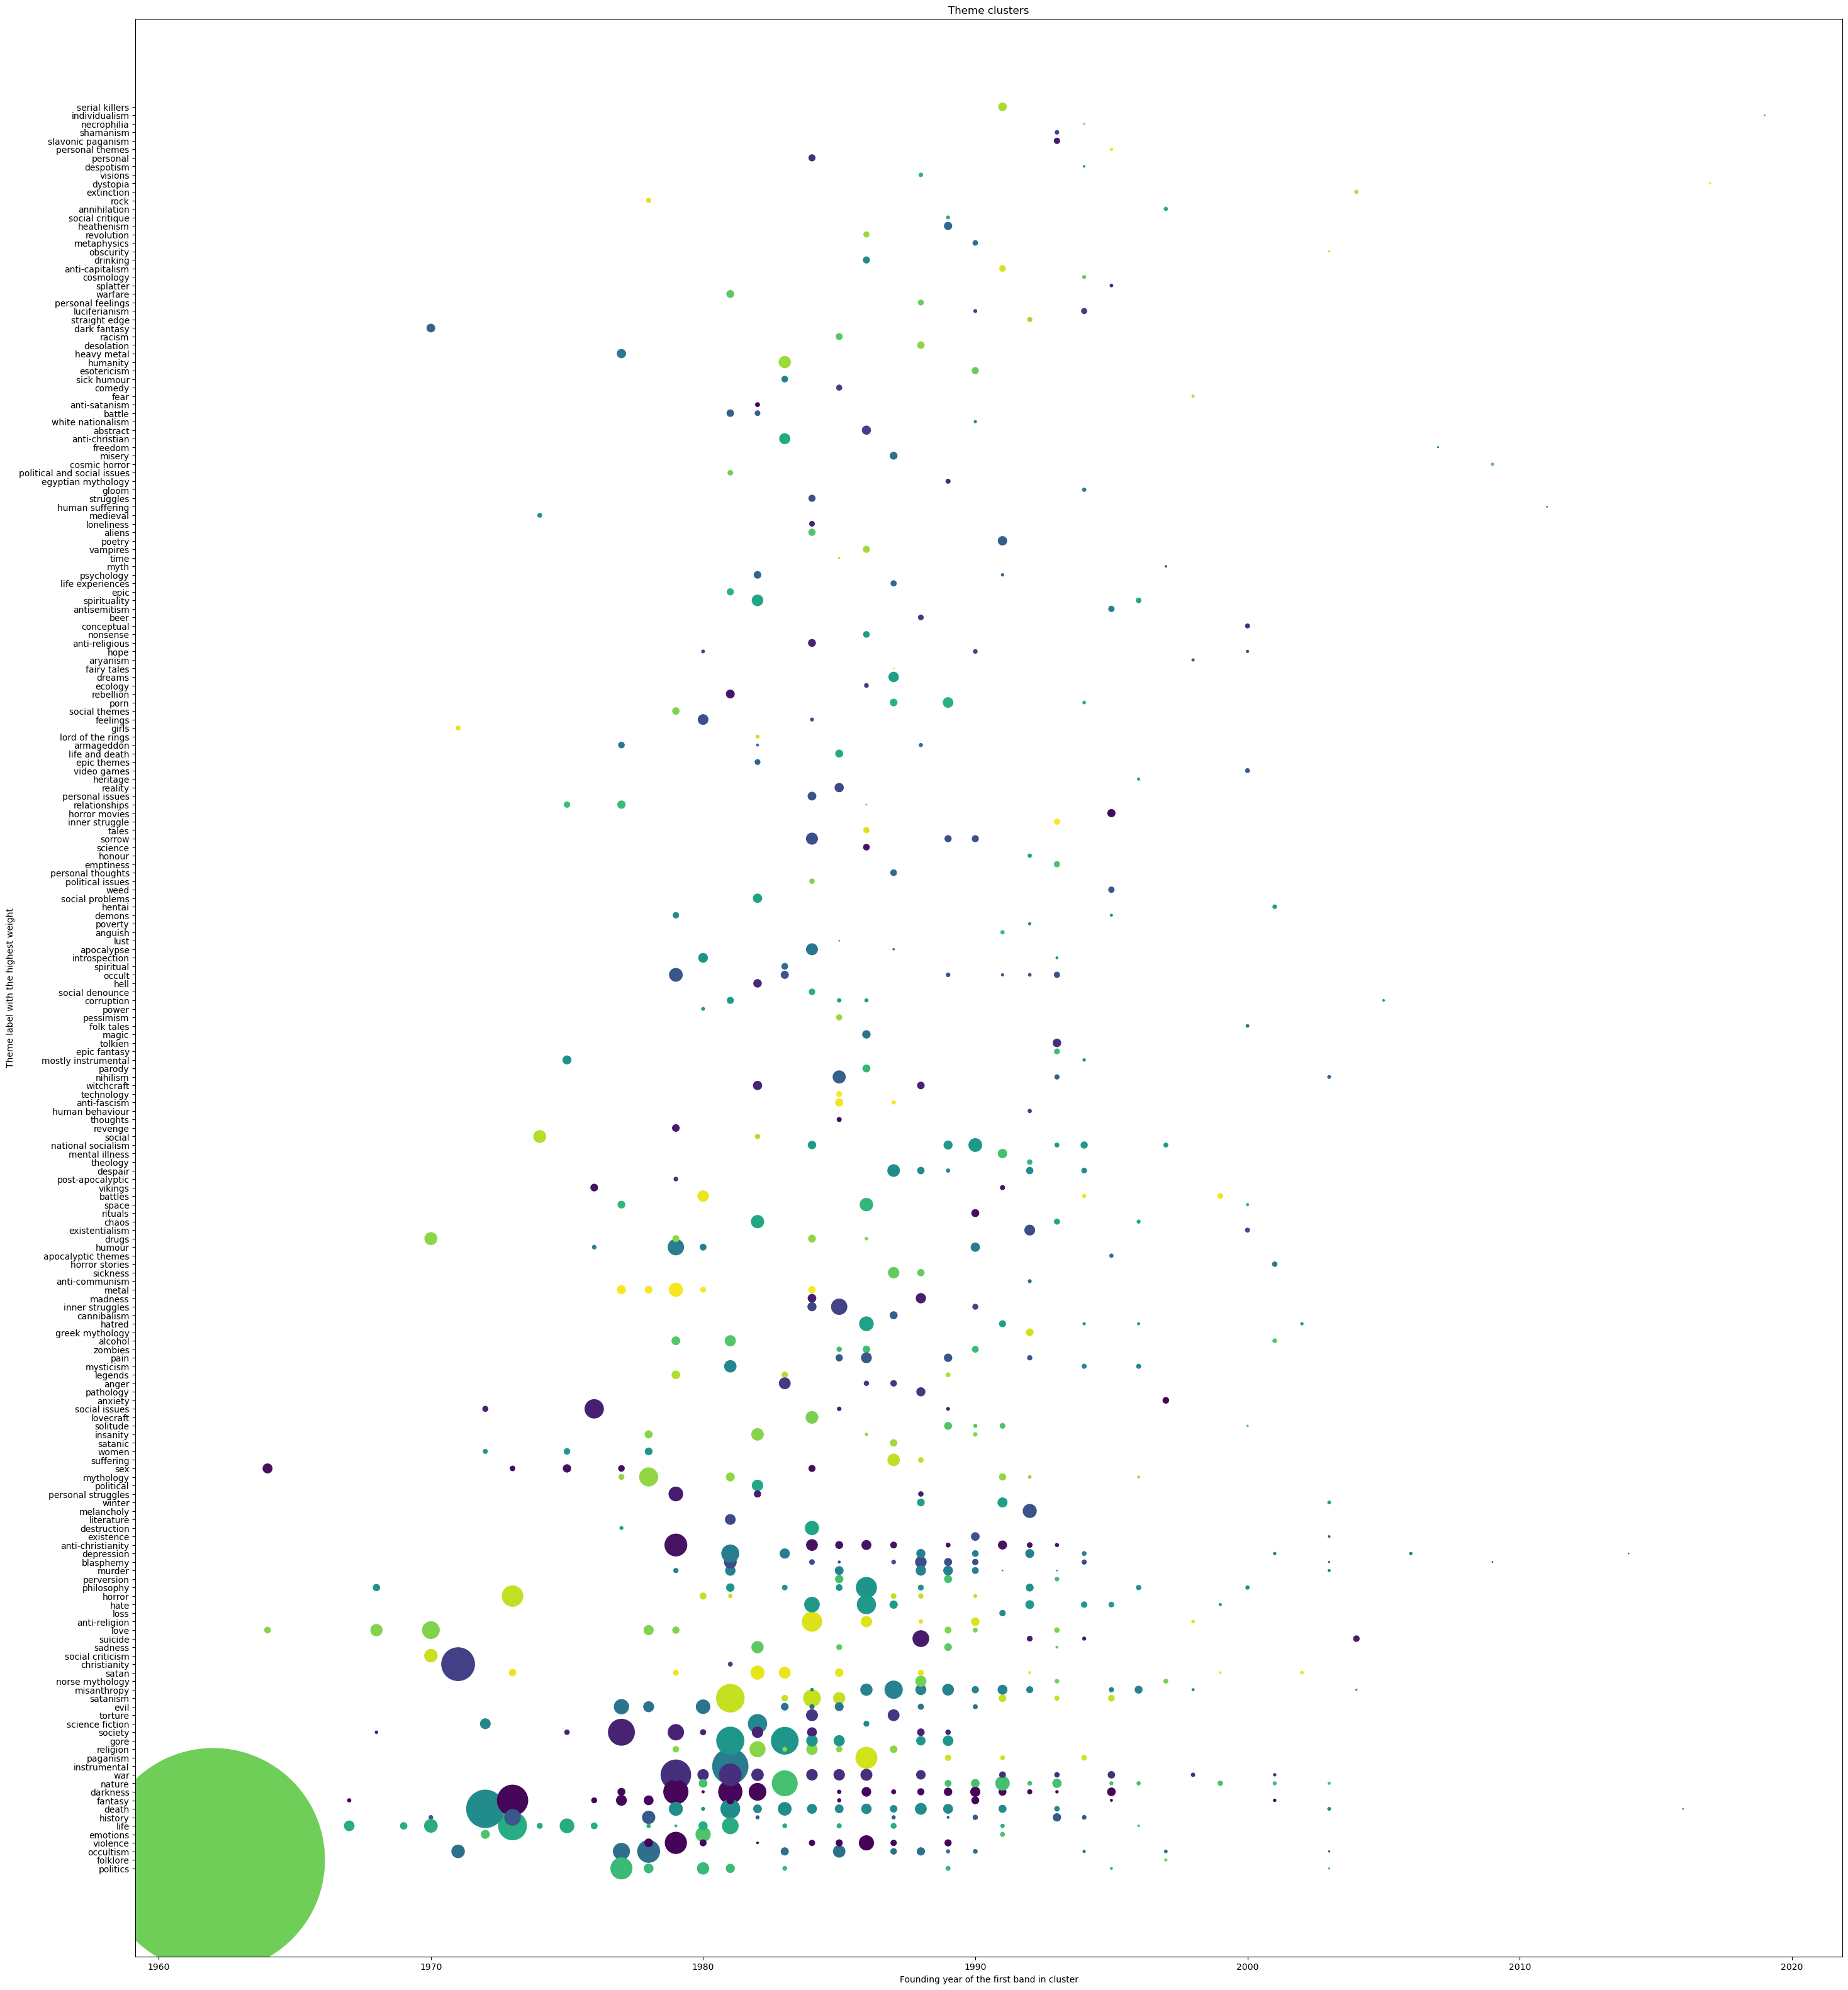

In [32]:
arr=theme_names[top_pos]

x=[]
c=[]
for i in range(len(arr)):
    x.append((arr[i][0]))
to_id = {v: i for i, v in enumerate(set(x))}
for i in range(len(arr)):
    c.append(to_id[(arr[i][0])])

weight=[]
for i in range(len(arr)):
    weight.append(groups.size()[i])
weight
w=np.array(weight)

plt.figure(figsize=(35,40))
plt.title('Theme clusters')
plt.xlabel('Founding year of the first band in cluster')
plt.ylabel('Theme label with the highest weight')
plt.scatter(groups['date'].first().astype(int),x,s=w,cmap='viridis', c=c);

The following is to discover whether each theme cluster has a tendency towards certain genres.

In [33]:
genre_by_theme = vec_avg(bands.shape[0], bands.index, kmeans.labels_, kmeans.cluster_centers_.shape[0], genre_mat)

These are the most important themes sorted descending according to the average of the genre weights.

In [34]:
top_pos = np.argsort(genre_by_theme)[:, -1 : -6 : -1]
genre_names[top_pos]

array([['death', 'thrash', 'melodic', 'grindcore', 'metalcore'],
       ['death', 'thrash', 'heavy', 'black', 'melodic'],
       ['black', 'death', 'thrash', 'doom', 'raw'],
       ...,
       ['atmospheric', 'black', 'viking', 'funeral', 'drone'],
       ['heavy', 'power', 'thrash', 'black', 'folk'],
       ['death', 'brutal', 'grindcore', 'thrash', 'doom']], dtype=object)

These are the average weights of the most important themes.

In [35]:
top = np.sort(genre_by_theme)[:, -1 : -6 : -1]
np.round(top, 2)

array([[0.55, 0.45, 0.36, 0.14, 0.09],
       [0.33, 0.23, 0.19, 0.17, 0.11],
       [0.87, 0.16, 0.07, 0.05, 0.03],
       ...,
       [1.  , 1.  , 0.  , 0.  , 0.  ],
       [0.52, 0.24, 0.19, 0.19, 0.14],
       [0.74, 0.24, 0.21, 0.15, 0.09]])

# 3. By Date and Location

In [36]:
bands_st = pd.read_csv('data/ma_bands_st.csv', index_col=0)
bands_st

name  \
index                              
2                      Scorpions   
3                Faithful Breath   
4                      Limelight   
5                    Deep Purple   
7                            Ash   
...                          ...   
128309                 Manawydan   
128310                Черновство   
128312                   Cineres   
128313              Dark Triumph   
128314  Contemptuous Infestation   

                                                      url  \
index                                                       
2       https://www.metal-archives.com/bands/Scorpions...   
3       https://www.metal-archives.com/bands/Faithful_...   
4       https://www.metal-archives.com/bands/Limelight...   
5       https://www.metal-archives.com/bands/Deep_Purp...   
7       https://www.metal-archives.com/bands/Ash/35404...   
...                                                   ...   
128309  https://www.metal-archives.com/bands/Manawydan...   
128310  https://www.metal-archives.com/bands/%D0%A7%D0...   
128312  https://www.metal-archives.com/bands/Cineres/3...   
128313  https://www.metal-archives.com/bands/Dark_Triu...   
128314  https://www.metal-archives.com/bands/Contemptu...   

                                                    genre  \
index                                                       
2                                   Heavy Metal/Hard Rock   
3       Progressive Rock (early); Heavy Metal/Hard Roc...   
4                            NWOBHM/Heavy Metal/Hard Rock   
5                                   Heavy Metal/Hard Rock   
7       Psychedelic Pop/Rock (early); Heavy Metal/Hard...   
...                                                   ...   
128309                                        Black Metal   
128310                               Black Metal, Ambient   
128312                                Melodic Black Metal   
128313                              Symphonic Black Metal   
128314                                 Brutal Death Metal   

                                                    theme  \
index                                                       
2       ['Life', ' Society', ' Love', ' Sex', ' Inner ...   
3                     ['Adventure', ' Fantasy', ' Women']   
4             ['Life', ' Feelings', ' Love', ' Thoughts']   
5       ["Rock 'n' Roll", ' Love', ' Relationships', '...   
7                                                     NaN   
...                                                   ...   
128309                   ['History / Indigenous history']   
128310                                                NaN   
128312                 ['Philosophy', ' Abstract themes']   
128313                   ['Agony', ' Darkness', ' Death']   
128314                                                NaN   

                       label         country  \
index                                          
2                        NaN         Germany   
3                        NaN         Germany   
4                        NaN  United Kingdom   
5                        NaN  United Kingdom   
7                        NaN       Australia   
...                      ...             ...   
128309  Unsigned/independent   United States   
128310  Unsigned/independent          Russia   
128312  Unsigned/independent        Slovakia   
128313  Unsigned/independent          Brazil   
128314  Unsigned/independent  United Kingdom   

                                   location        status    date  \
index                                                               
2                    Hannover, Lower Saxony        Active  1964.0   
3            Witten, North Rhine-Westphalia  Changed name  1967.0   
4       Mansfield, Nottinghamshire, England      Split-up  1967.0   
5          Hertford, Hertfordshire, England        Active  1968.0   
7                       Melbourne, Victoria      Split-up  1968.0   
...                                     ...           ...     ...   


Bands are divided by the decade of their founding date, before being clustered by their locations. The only clustering algorithm suitable for geospatial data is DBSCAN, which clusters high density points together. Eps defines the maximum distance between neighboring points. It selection is relatively subjective, and my criterion is that it should be around the largest value that groups bands in Sweden and Germany in two clusters. The number of minimum samples in a cluster is found by a binary search so that the bands in the clusters should be about half of the total number of the bands.

The top two genres and top two themes of each cluster are then labelled on the map.

In [37]:
from sklearn.cluster import DBSCAN

def dbscan_find(data, ratio):
    l = 1
    r = data.shape[0]
    
    while l < r:
        mid = (l + r + 1) // 2
        dbscan = DBSCAN(eps=0.015, min_samples=mid, metric='haversine')
        dbscan.fit(data)
        if np.sum(dbscan.labels_ >= 0) / data.shape[0] >= ratio:
            l = mid
        else:
            r = mid - 1

    return l

The following function adjusts the positions of the labels to avoid overlaps if possible. 

In [38]:
from math import sqrt

def adjust_loc(loc, lat_min, lon_min, iteration, ratio):
    def sign(x):
        if x >= 0:
            return 1
        else:
            return -1
    
    for i in range(iteration):
        for id0, row0 in loc.iterrows():
            for id1, row1 in loc.iterrows():
                if id0 == id1: continue
                lat_del = row1['lat'] - row0['lat']
                lon_del = row1['lon'] - row0['lon']

                if abs(lat_del) < lat_min and abs(lon_del) < lon_min:
                    lat_del = sign(lat_del) * (lat_min - abs(lat_del)) / 2 * ratio
                    row1['lat'] += lat_del
                    row0['lat'] -= lat_del

                    lon_del = sign(lon_del) * (lon_min - abs(lon_del)) / 2 * ratio
                    row1['lon'] += lon_del
                    row0['lon'] -= lon_del

9
10 10
9
238 475
17
3901 7799
27
10603 21052
27
21619 42429
37
16356 32503


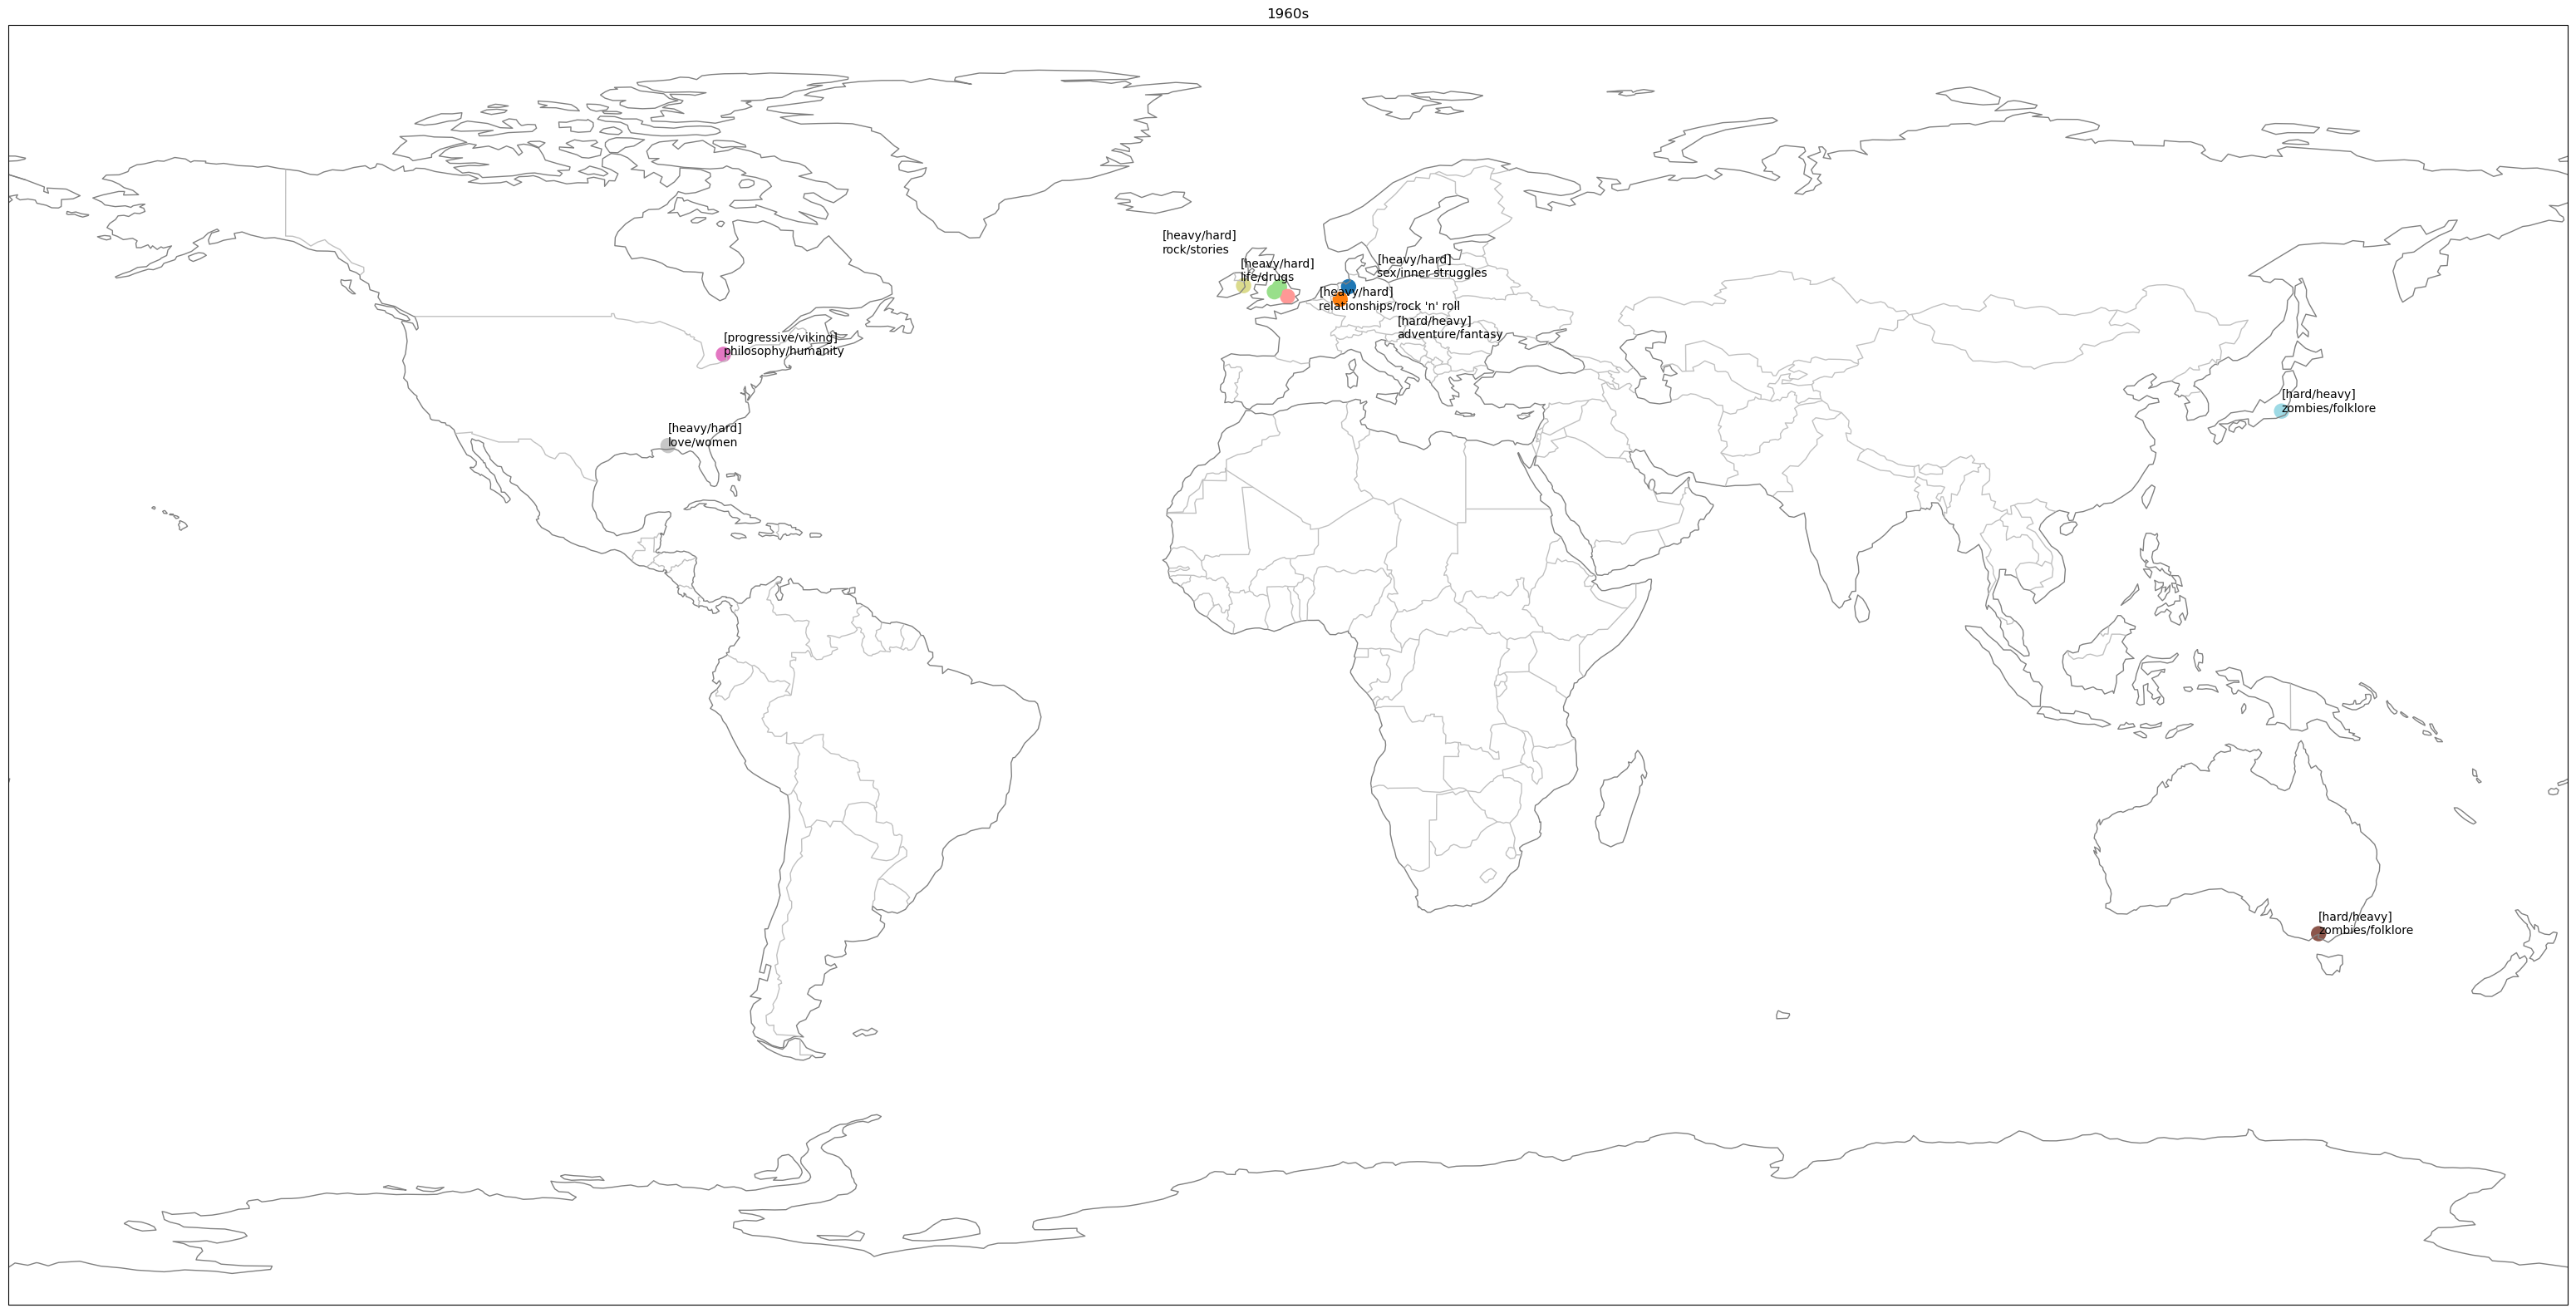

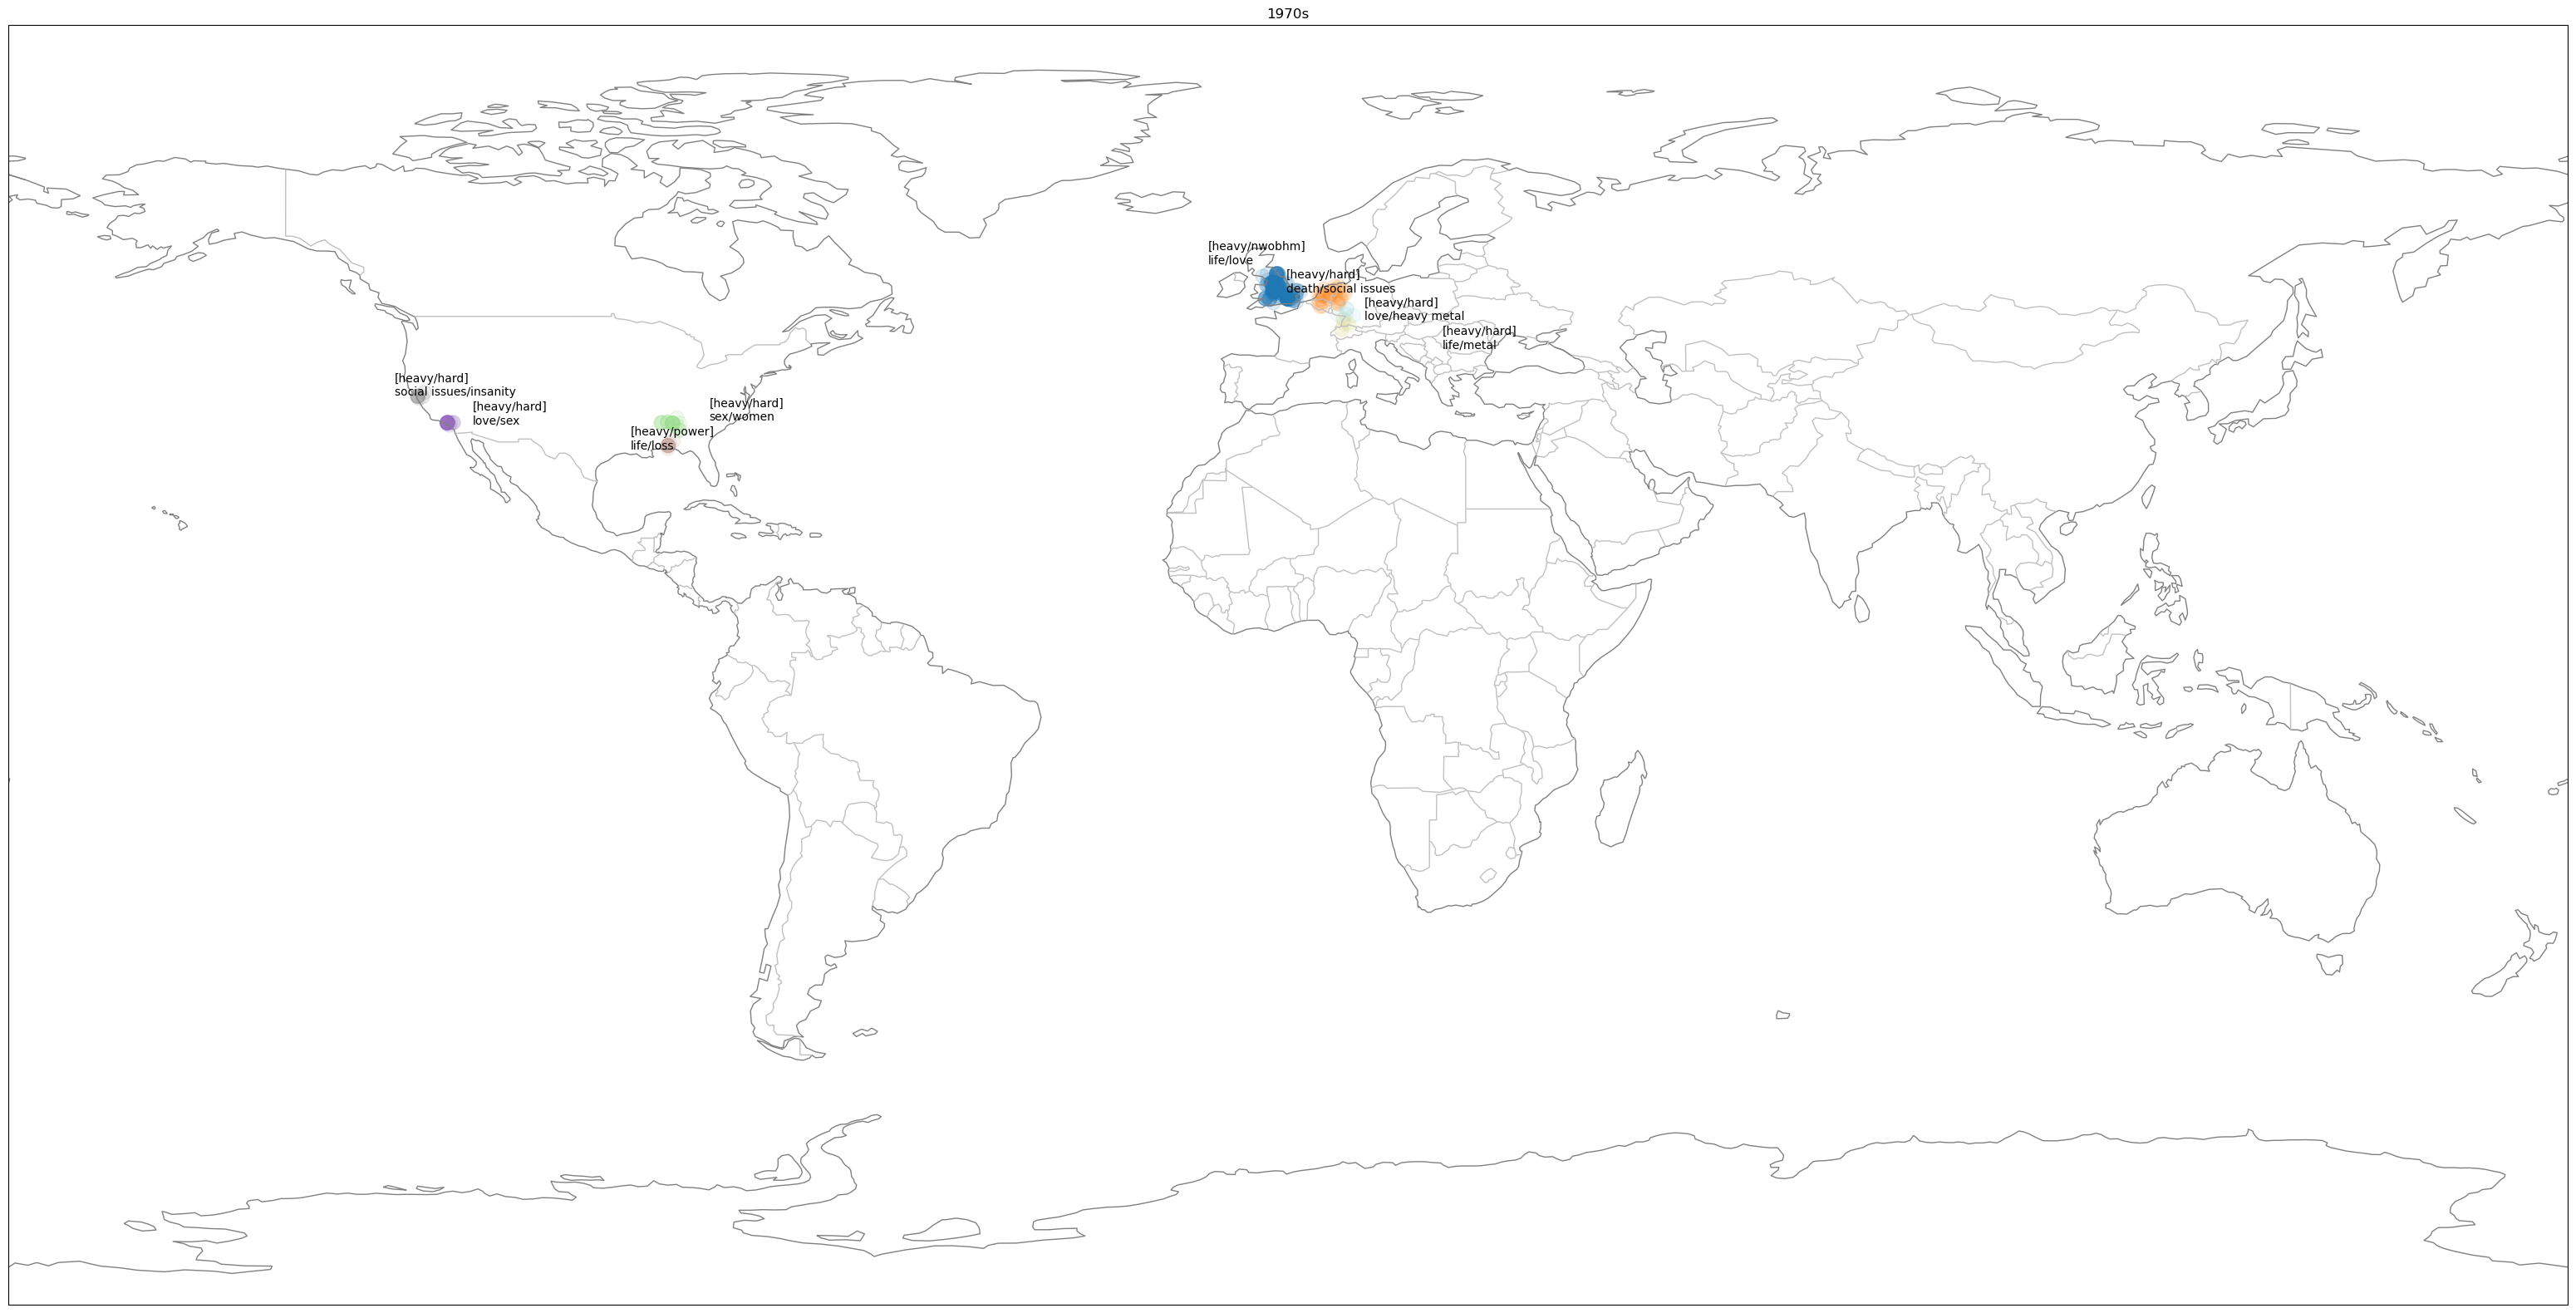

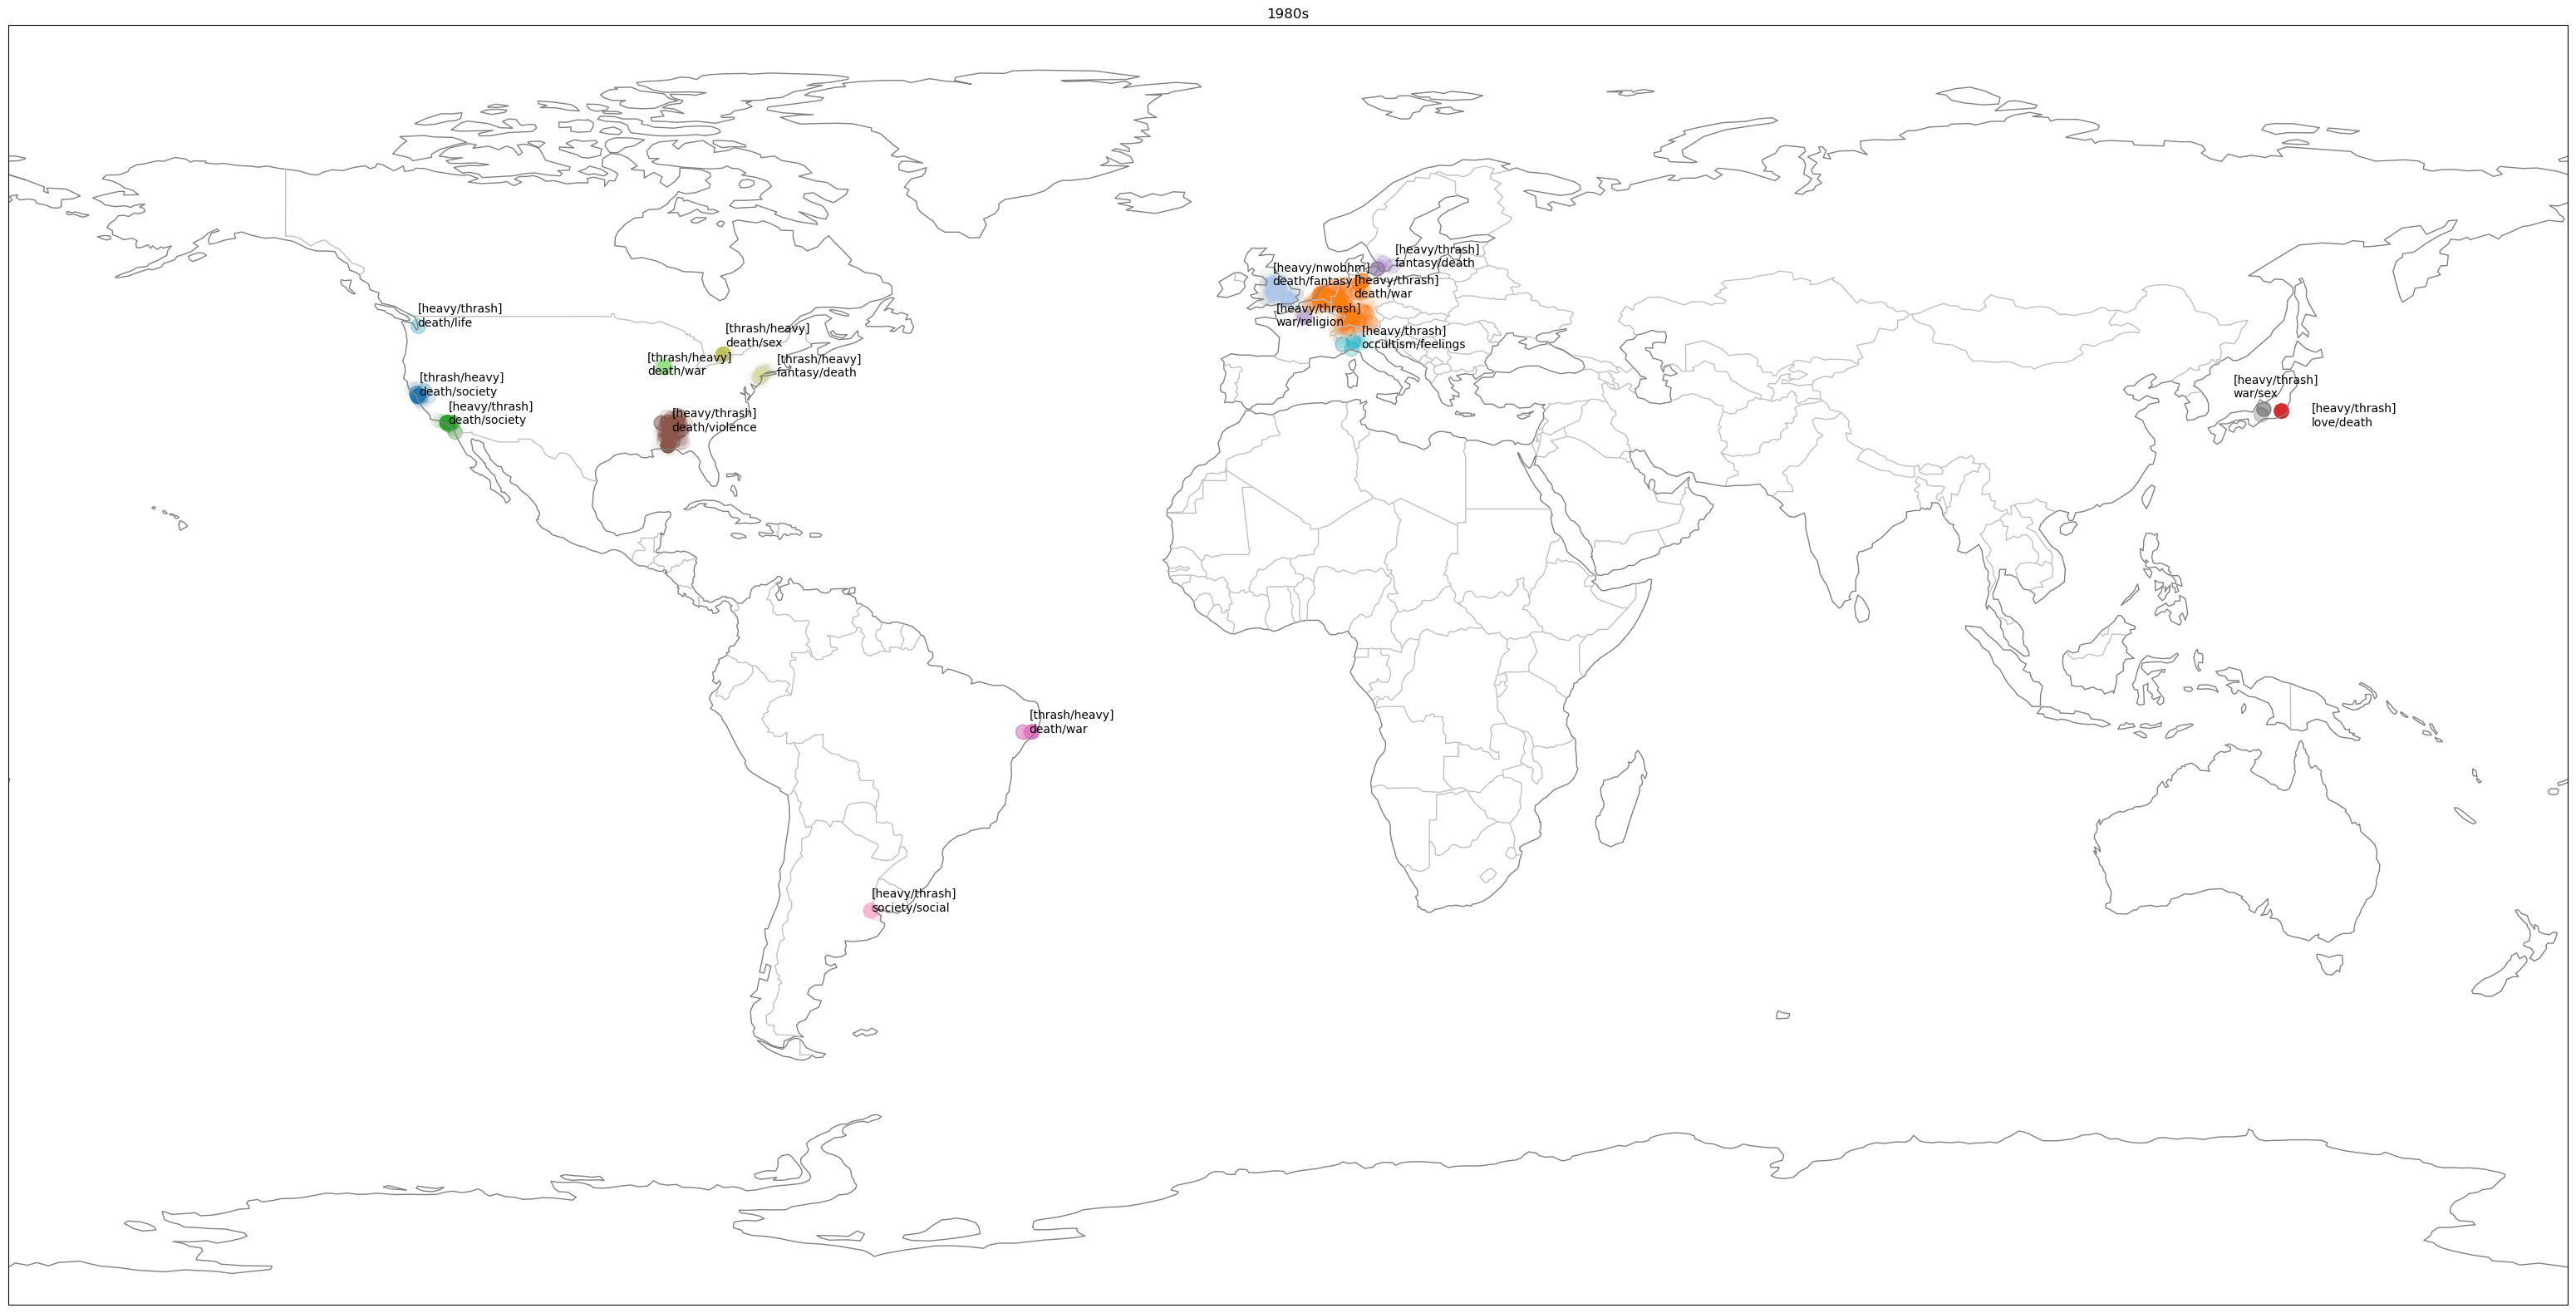

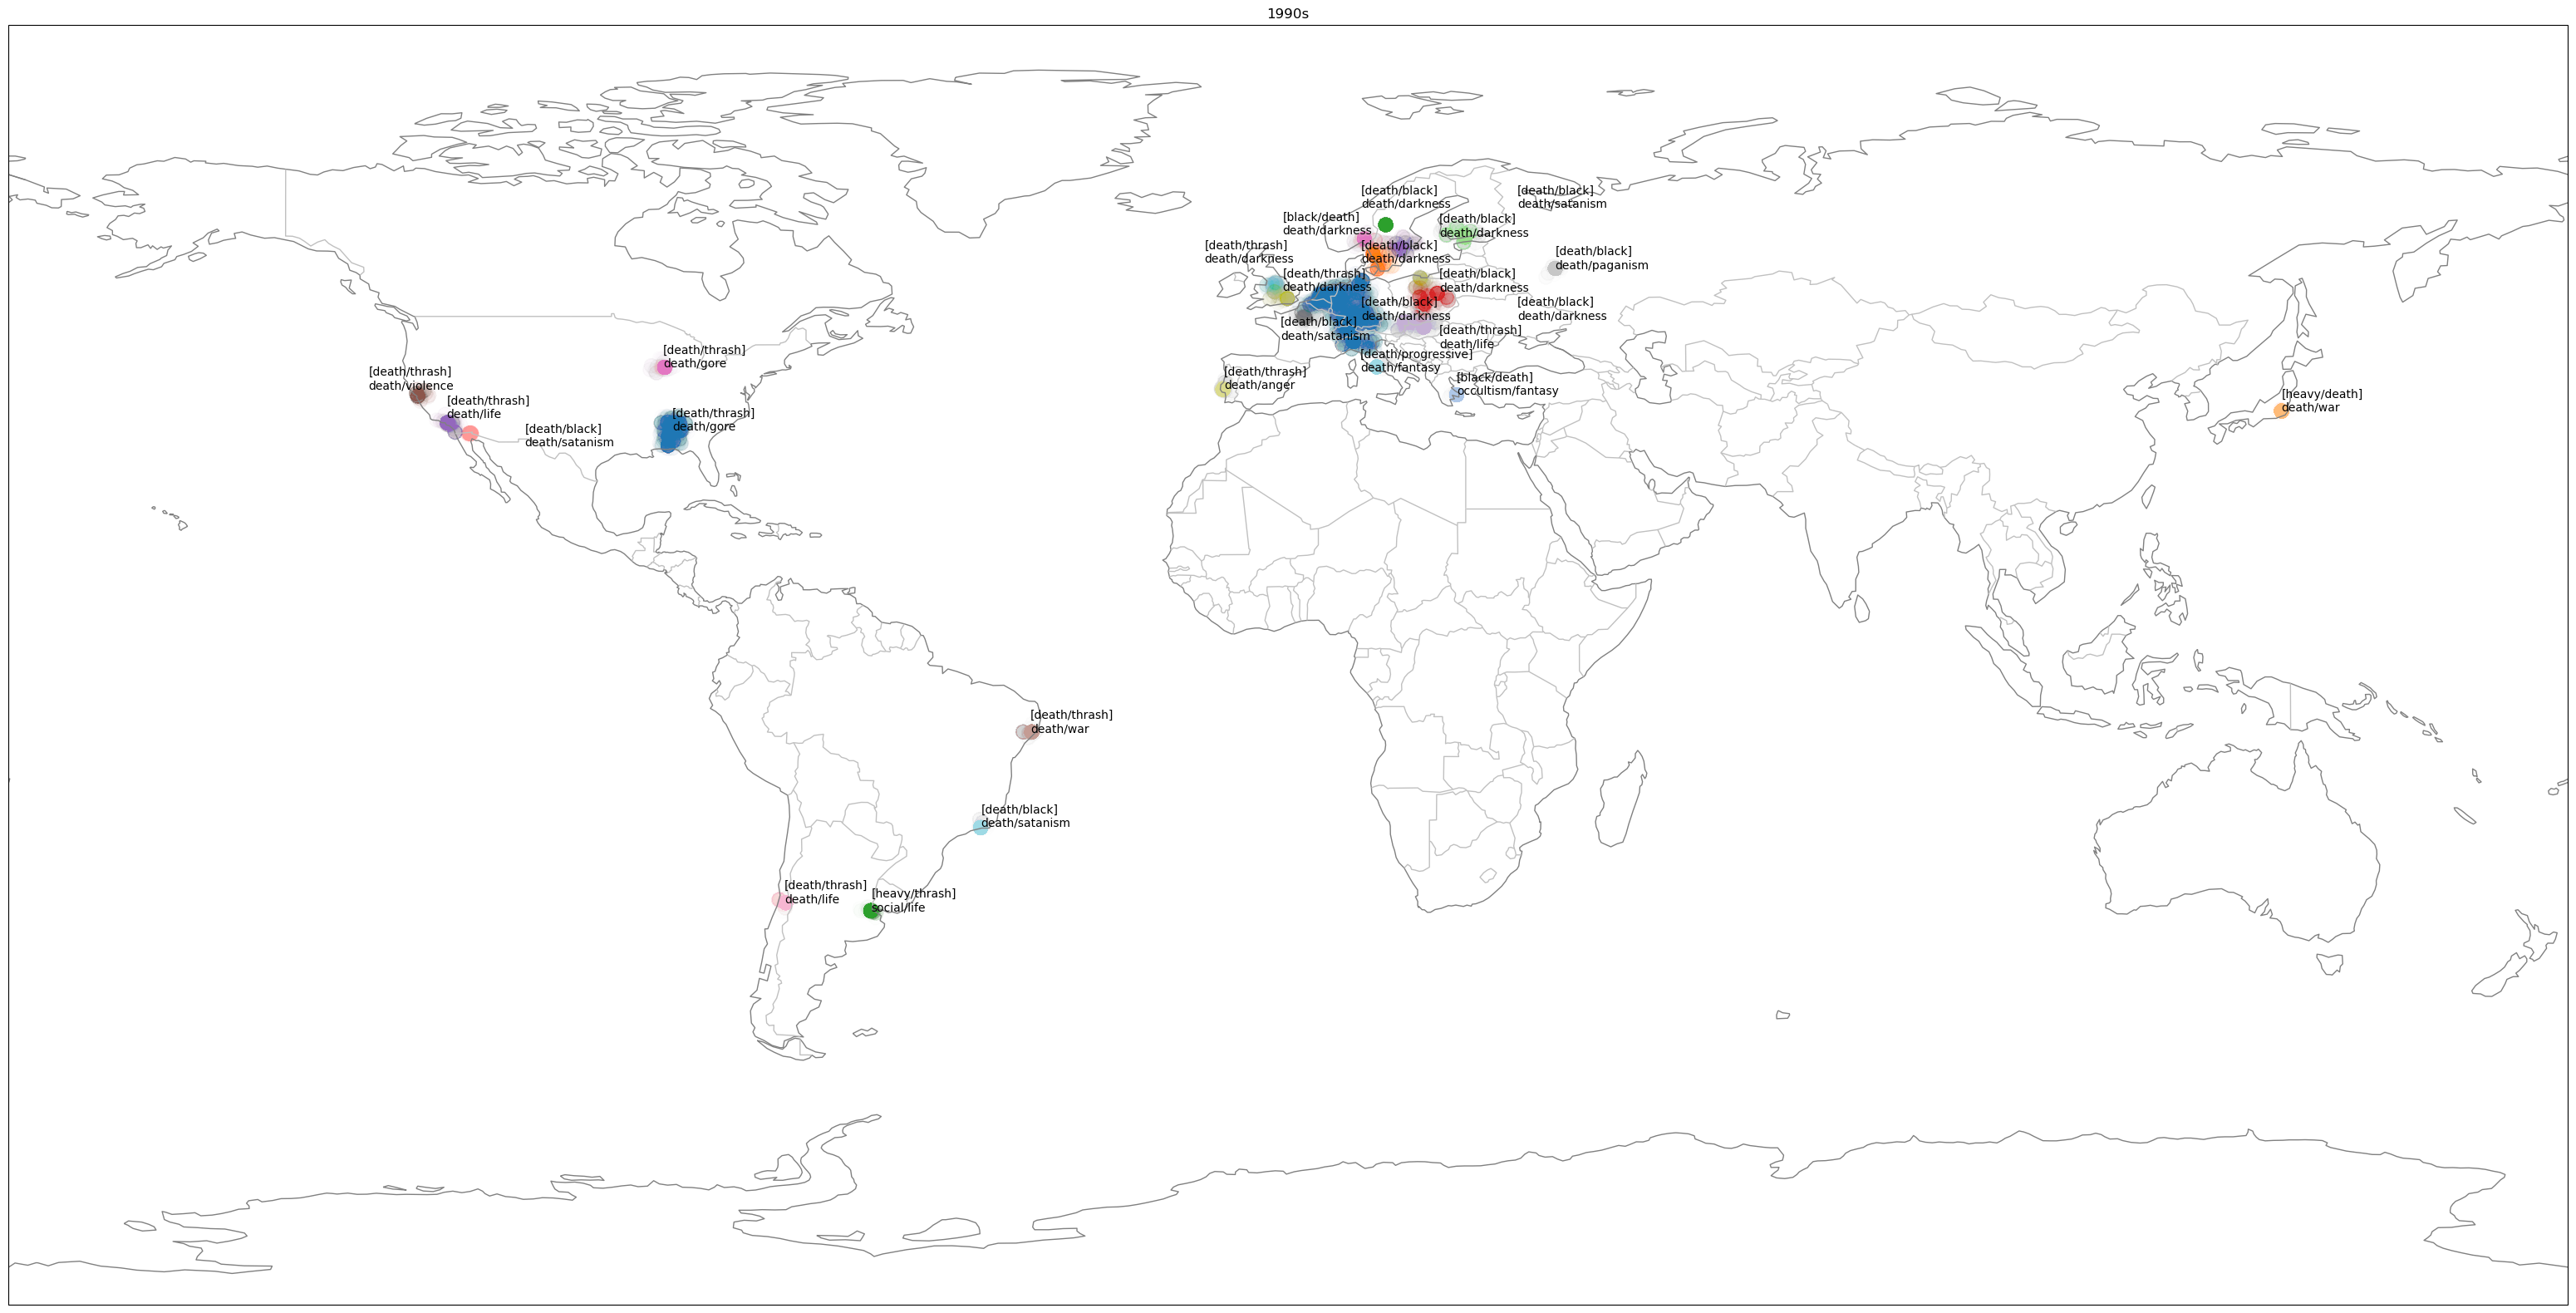

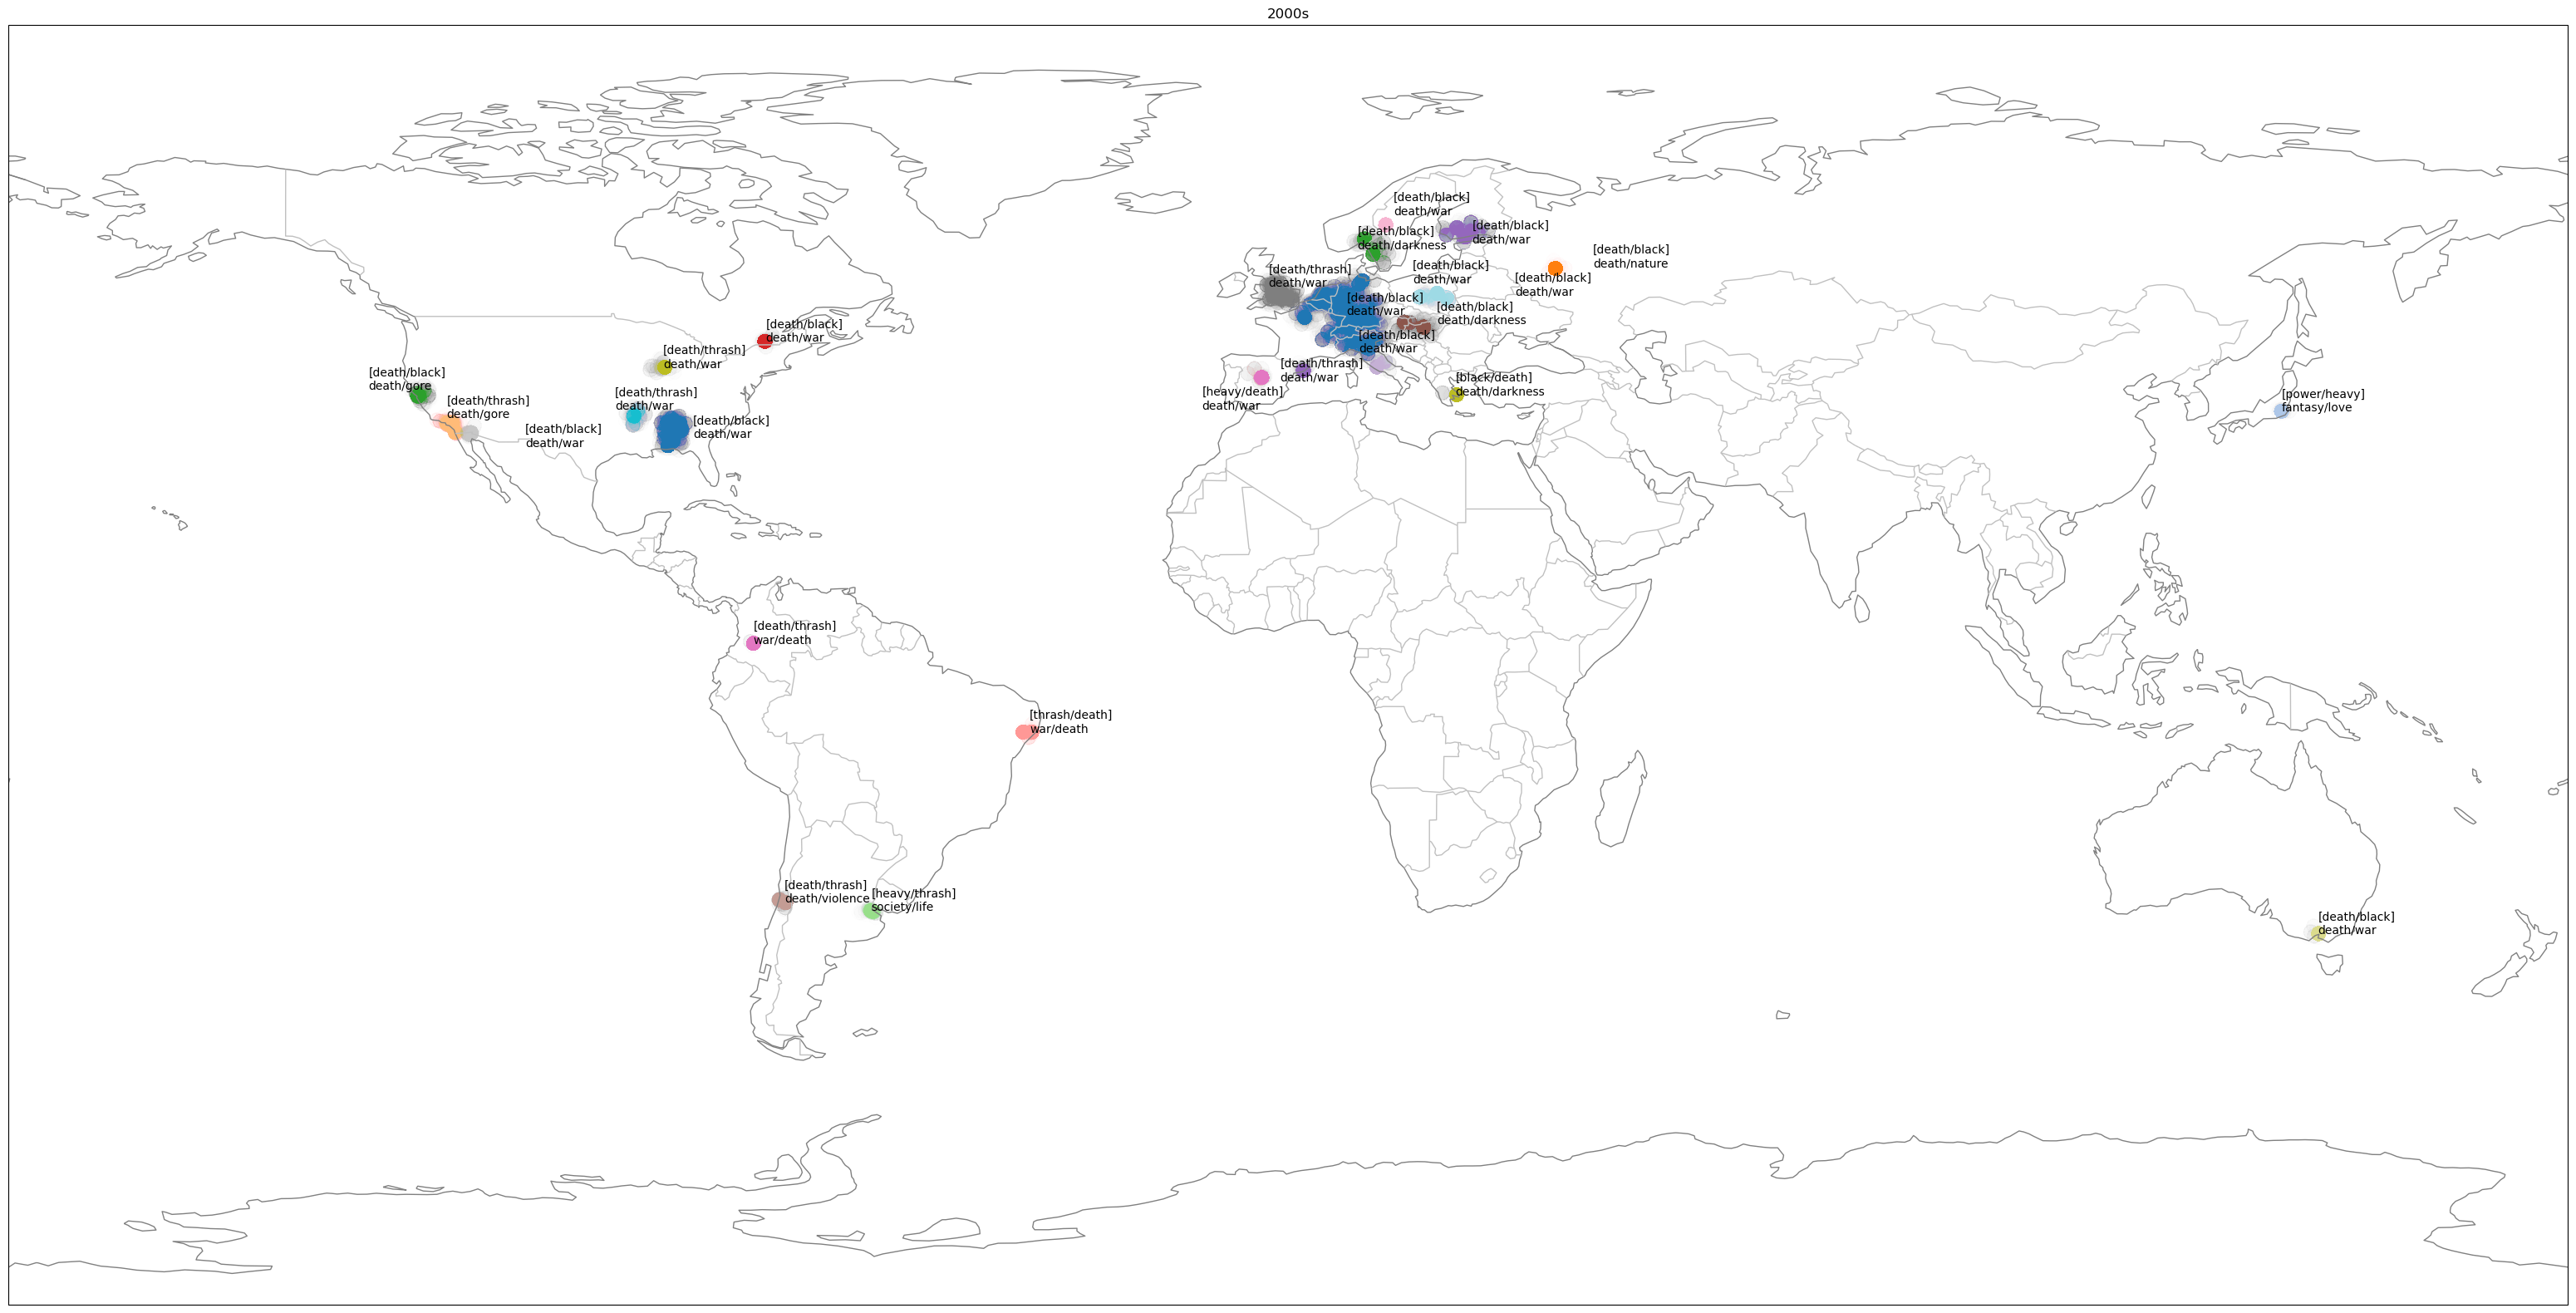

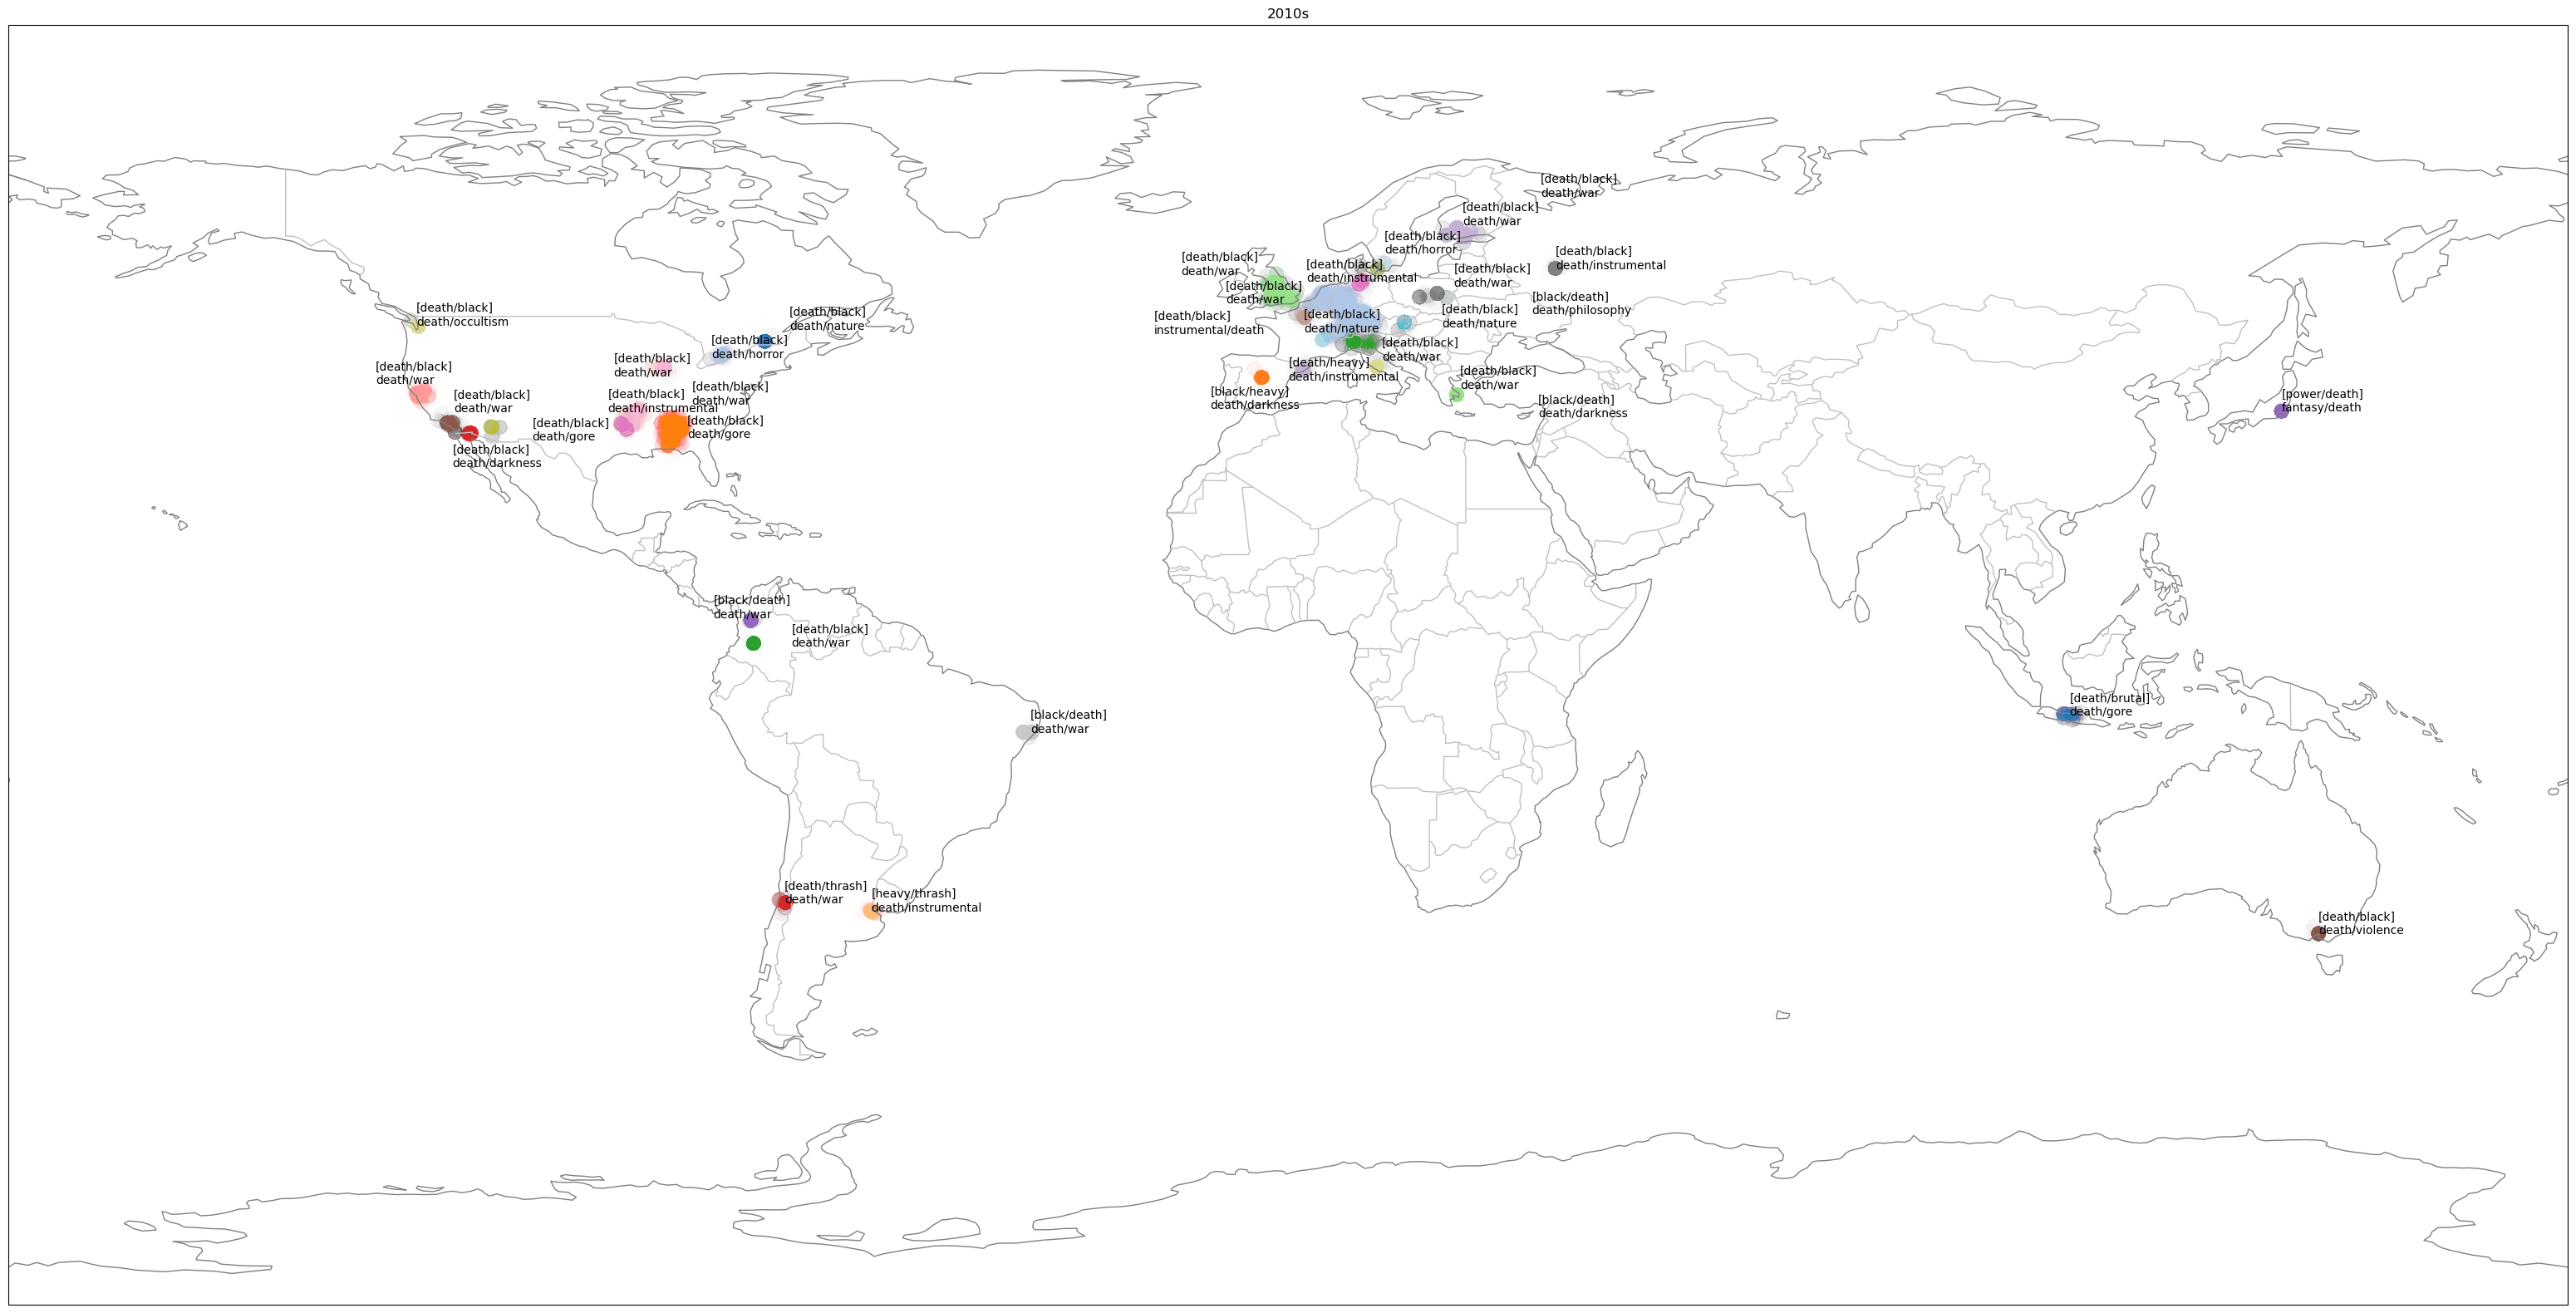

In [39]:
from sklearn.cluster import DBSCAN
import cartopy.crs as ccrs
import cartopy.feature as cf

decades = [196, 197, 198, 199, 200, 201]

for i, decade in enumerate(decades):
    proj = ccrs.PlateCarree()
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': proj}, figsize=(40, 20))
    ax.add_feature(cf.COASTLINE, edgecolor='Grey')
    ax.add_feature(cf.BORDERS, edgecolor='Silver')
    ax.set_extent([-180, 180, -90, 90])
    ax.set_title(str(decade) + '0s')
    
    bands_dec = bands_st[bands_st['date'].astype(int) // 10 == decade]
    loc_rad = bands_dec[['lat', 'lon']].apply(np.radians)
    min_size = dbscan_find(loc_rad, 0.5)
    dbscan = DBSCAN(eps=0.015, min_samples=min_size, metric='haversine')
    dbscan.fit(loc_rad)
    
    ax.scatter(bands_dec[dbscan.labels_ >= 0]['lon'], bands_dec[dbscan.labels_ >= 0]['lat'], marker='o', s=150,
               c=dbscan.labels_[dbscan.labels_ >= 0], alpha=1 / min_size, cmap='tab20',
               transform=proj)
    
    center = bands_dec[dbscan.labels_ >= 0][['lat', 'lon']].groupby(dbscan.labels_[dbscan.labels_ >= 0]).mean()
    adjust_loc(center, 4, 11, 300, 0.1)
    
    genre_cluster = vec_avg(bands.shape[0], bands_dec[dbscan.labels_ >= 0].index,
                            dbscan.labels_[dbscan.labels_ >= 0],
                            np.unique(dbscan.labels_[dbscan.labels_ >= 0]).shape[0],
                            genre_mat)
    top_pos = np.argsort(genre_cluster)[:, -1 : -3 : -1]
    top_genre = genre_names[top_pos]
    
    theme_cluster = vec_avg(bands.shape[0], bands_dec[dbscan.labels_ >= 0].index,
                            dbscan.labels_[dbscan.labels_ >= 0],
                            np.unique(dbscan.labels_[dbscan.labels_ >= 0]).shape[0],
                            theme_mat)
    top_pos = np.argsort(theme_cluster)[:, -1 : -3 : -1]
    top_theme = theme_names[top_pos]
    
    for j in range(center.shape[0]):
        plt.text(center['lon'][j], center['lat'][j],
                 '[' + top_genre[j][0] + '/' + top_genre[j][1] + ']\n' + top_theme[j][0] + '/' + top_theme[j][1],
                 color='k', transform=proj)
    
    print(np.unique(dbscan.labels_).shape[0])
    print(np.sum(dbscan.labels_ >= 0), bands_dec.shape[0])